# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. 3 & Fig. 6 & Fig. S2: time series of pH, omega_arag, omega_calc in MPAs (top 200m and bottom)
#
# this script requires post-processed model output

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
#---
# general info
#---

# where are the data? (names of *nc files are hard-coded in 'get_data()' function below)
path_to_data = '/global/homes/c/cnissen/ARCHIVE_Nissen2023_NatureComms_OA_in_MPAs/nc_files/'
#'/pscratch/sd/c/cnissen/carbonate_chemistry_3D_v2/regional/' 

savepath1    = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_TimeSeries/'
if not os.path.exists(savepath1):
    print('Created '+savepath1)
    os.makedirs(savepath1)
    
savepath2    = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_TimeSeries/eps/'
if not os.path.exists(savepath2):
    print('Created '+savepath2)
    os.makedirs(savepath2)
    

In [3]:
#---
# function to load variables
#---

def get_data(vari1,vari2,path_to_data):
    #
    # NOTE: Regional averages for the Antarctic Peninsula MPA (shelf vs. open ocean) were stored 
    # in a separate file from the other regions; combine the data to a single file here
    #
    
    print ('Load ',vari1,vari2)
    
    file1 = 'Carbonate_chemistry_regional_simAssp585_1990_2100_v3.nc'
    file2 = 'Carbonate_chemistry_regional_simAssp370_2015_2100_v3.nc'
    file3 = 'Carbonate_chemistry_regional_simAssp245_2015_2100_v3.nc'
    file4 = 'Carbonate_chemistry_regional_simAssp126_2015_2100_v3.nc'
    file5 = 'Carbonate_chemistry_regional_simAssp585_1990_2100_v3.nc' 

    ff1 = Dataset(path_to_data + file1)
    ff2 = Dataset(path_to_data + file2)
    ff3 = Dataset(path_to_data + file3)
    ff4 = Dataset(path_to_data + file4)
    ff5 = Dataset(path_to_data + file5)
   
    dataA_1 = ff1.variables[vari1][:,:,:] # month x year x subregion
    dataA_2 = ff2.variables[vari1][:,:,:]
    dataA_3 = ff3.variables[vari1][:,:,:]
    dataA_4 = ff4.variables[vari1][:,:,:]
    dataA_5 = ff5.variables[vari1][:,:,:]

    dataC_1 = ff1.variables[vari2][:,:,:] # month x year x subregion
    dataC_2 = ff2.variables[vari2][:,:,:]
    dataC_3 = ff3.variables[vari2][:,:,:]
    dataC_4 = ff4.variables[vari2][:,:,:]
    dataC_5 = ff5.variables[vari2][:,:,:]

    # for ssp370, ssp245 & ssp126, add historical years to beginning of array 
    # (for these scenarios, data were only post-processed and stored in file from 2015 to 2100)
    fill_array = np.nan*np.ones([dataA_1.shape[0],25,dataA_1.shape[2]])
    dataA_2 = np.concatenate((fill_array,dataA_2),axis=1)
    dataA_3 = np.concatenate((fill_array,dataA_3),axis=1)
    dataA_4 = np.concatenate((fill_array,dataA_4),axis=1)
    dataC_2 = np.concatenate((fill_array,dataC_2),axis=1)
    dataC_3 = np.concatenate((fill_array,dataC_3),axis=1)
    dataC_4 = np.concatenate((fill_array,dataC_4),axis=1)

    ff1.close()
    ff2.close()
    ff3.close()
    ff4.close()
    ff5.close()
    
    data_all_Arag_1 = np.stack((dataA_1,dataA_2,dataA_3,dataA_4,dataA_5),axis=3)
    data_all_Calc_1 = np.stack((dataC_1,dataC_2,dataC_3,dataC_4,dataC_5),axis=3)
    #print ('data_all_Arag.shape:',data_all_Arag_1.shape)
    
    #---
    # load Antarctic Peninsula separately
    #---
    file1 = 'Carbonate_chemistry_regional_simAssp585_1990_2100_v4_AntarcticPeninsula_only.nc'
    file2 = 'Carbonate_chemistry_regional_simAssp370_2015_2100_v4_AntarcticPeninsula_only.nc'
    file3 = 'Carbonate_chemistry_regional_simAssp245_2015_2100_v4_AntarcticPeninsula_only.nc'
    file4 = 'Carbonate_chemistry_regional_simAssp126_2015_2100_v4_AntarcticPeninsula_only.nc'
    file5 = 'Carbonate_chemistry_regional_simAssp585_1990_2100_v4_AntarcticPeninsula_only.nc' #'Carbonate_chemistry_regional_simB_1990_2100_v3.nc'

    ff1 = Dataset(path_to_data + file1)
    ff2 = Dataset(path_to_data + file2)
    ff3 = Dataset(path_to_data + file3)
    ff4 = Dataset(path_to_data + file4)
    ff5 = Dataset(path_to_data + file5)
   
    dataA_1 = ff1.variables[vari1][:,:,:] # month x year x subregion
    dataA_2 = ff2.variables[vari1][:,:,:]
    dataA_3 = ff3.variables[vari1][:,:,:]
    dataA_4 = ff4.variables[vari1][:,:,:]
    dataA_5 = ff5.variables[vari1][:,:,:]

    dataC_1 = ff1.variables[vari2][:,:,:] # month x year x subregion
    dataC_2 = ff2.variables[vari2][:,:,:]
    dataC_3 = ff3.variables[vari2][:,:,:]
    dataC_4 = ff4.variables[vari2][:,:,:]
    dataC_5 = ff5.variables[vari2][:,:,:]

    # for ssp370, ssp245 & ssp126, add historical years to beginning of array 
    # (for these scenarios, data were only post-processed and stored in file from 2015 to 2100)
    fill_array = np.nan*np.ones([dataA_1.shape[0],25,dataA_1.shape[2]])
    dataA_2 = np.concatenate((fill_array,dataA_2),axis=1)
    dataA_3 = np.concatenate((fill_array,dataA_3),axis=1)
    dataA_4 = np.concatenate((fill_array,dataA_4),axis=1)
    dataC_2 = np.concatenate((fill_array,dataC_2),axis=1)
    dataC_3 = np.concatenate((fill_array,dataC_3),axis=1)
    dataC_4 = np.concatenate((fill_array,dataC_4),axis=1)

    ff1.close()
    ff2.close()
    ff3.close()
    ff4.close()
    ff5.close()
    
    data_all_Arag_2 = np.stack((dataA_1,dataA_2,dataA_3,dataA_4,dataA_5),axis=3)
    data_all_Calc_2 = np.stack((dataC_1,dataC_2,dataC_3,dataC_4,dataC_5),axis=3)
    # print ('data_all_Arag.shape:',data_all_Arag_2.shape)
    
    # stack both files to have all regions in a single file
    data_all_Arag = np.concatenate((data_all_Arag_1,data_all_Arag_2),axis=2)
    data_all_Calc = np.concatenate((data_all_Calc_1,data_all_Calc_2),axis=2)
    
    print ('data_all_Arag.shape (months x years x regions x simulations):',data_all_Arag.shape)
    
    return data_all_Arag,data_all_Calc


In [4]:
#-----
# COLOR SCHEME
#-----
cc1 = (52./255.,103./255.,92./255.) # pine
cc2 = (161./255.,190./255.,149./255.) # sage
cc3 = (45./255.,66./255.,98./255.) # indigo
cc4 = (248./255.,160./255.,85./255.) # Canteloupe
cc5 = (186./255.,168./255.,150./255.) # warm grey
cc6 = (0./255.,0./255.,0./255.) # black

# Ross: 
color_list1 = [(0./255.,59./255.,70./255.),(102./255.,165./255.,173./255.),(196./255.,223./255.,230./255.),\
                  (0.82,0.82,0.82)]
# eastAA: 
color_list2 = [(75./255.,116./255.,71./255.),(161./255.,190./255.,149./255.),(201./255.,209./255.,200./255.),\
                  (0.82,0.82,0.82)]
# Weddell: 
color_list3 = [(26./255.,64./255.,95./255.),(51./255.,123./255.,174./255.),(208./255.,225./255.,249./255.),\
                  (0.82,0.82,0.82)]
# Orkney: 
color_list4 = [(164./255.,56./255.,32./255.),(238./255.,105./255.,36./255.),(248./255.,160./255.,85./255.),\
                  (0.82,0.82,0.82)]
# WAP: 
color_list5 = [(80./255.,49./255.,47./255.),(186./255.,168./255.,150./255.),(230./255.,204./255.,181./255.),\
                  (0.82,0.82,0.82)]
# grey scale for areas that are not MPAs
color_list6 = [(0./255.,0./255.,0./255.),(75./255.,75./255.,75./255.),(150./255.,150./255.,150./255.),\
                  (0.82,0.82,0.82)]
  
color1 = (0.28,0.28,0.28) #'dimgrey'
    

Process  top200
Load  pH_avg_top200 omegaA_avg_top200
data_all_Arag.shape (months x years x regions x simulations): (12, 111, 31, 5)
Process  RossSea_MPA top200
Also load  RossSea_MPA_shelf


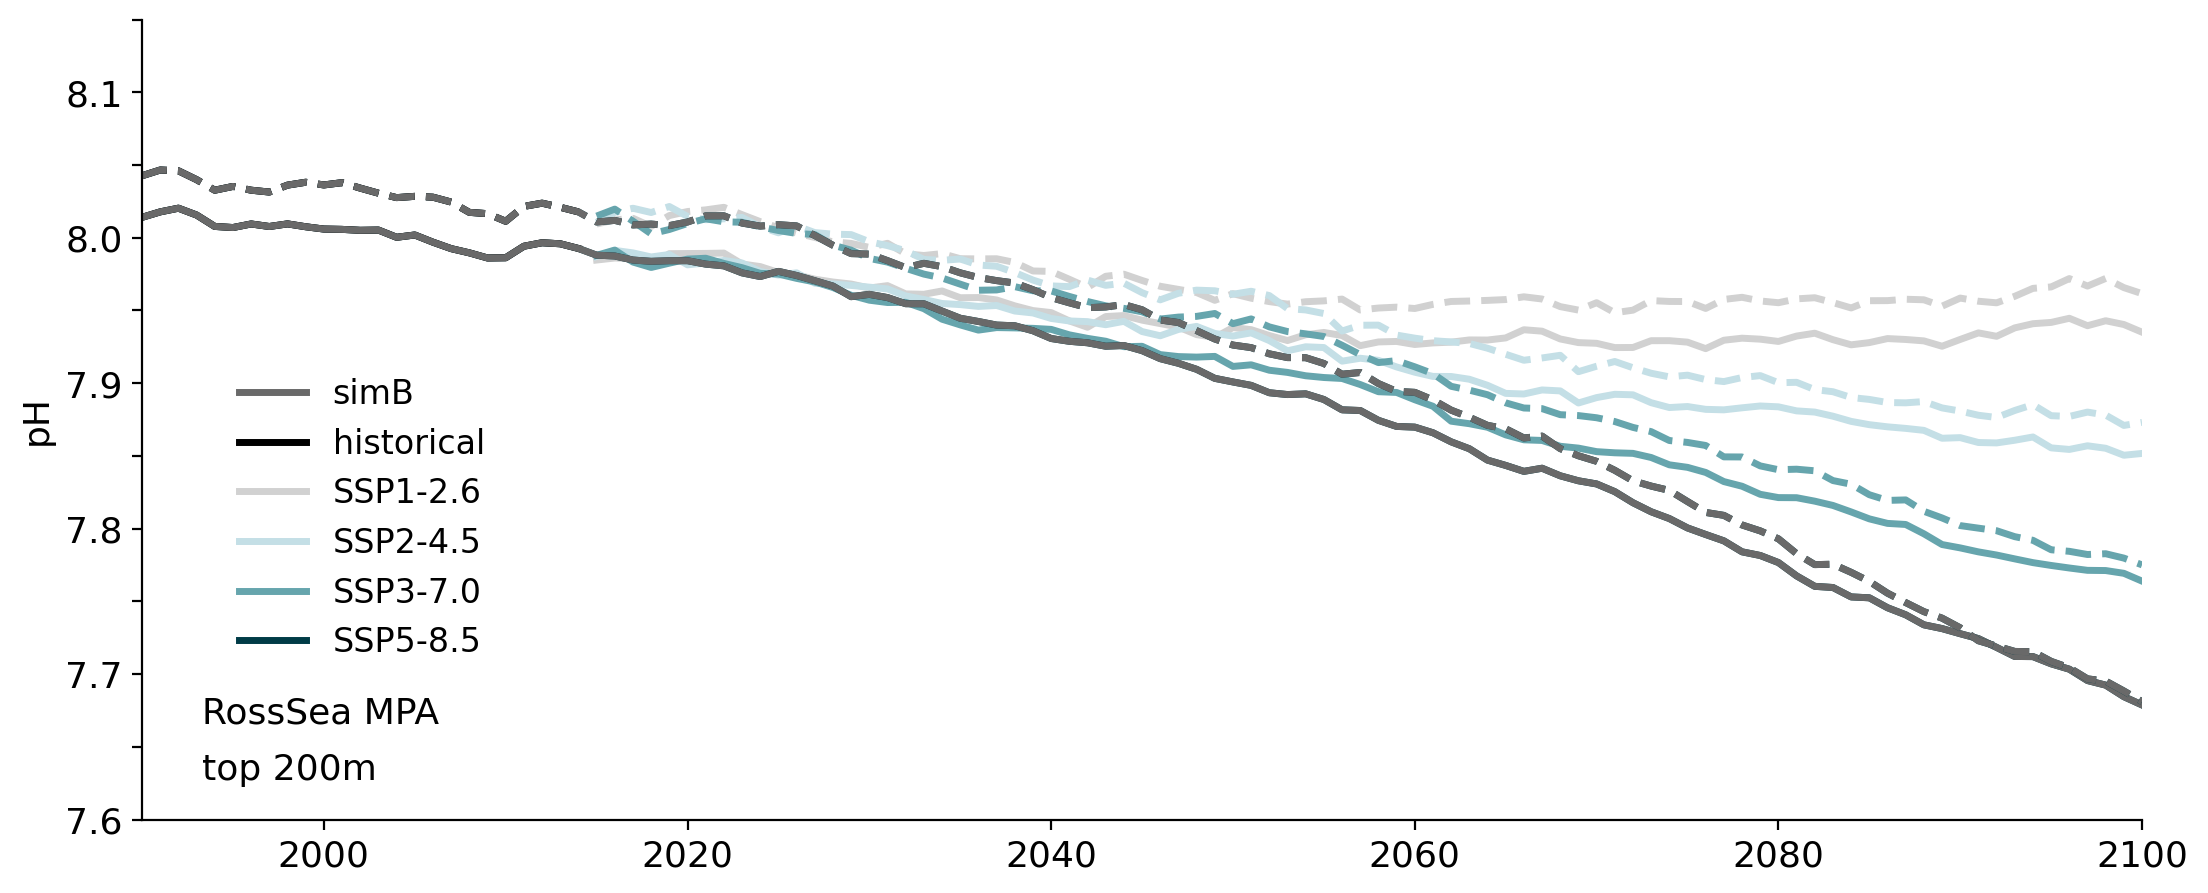

Process  WeddellSea_MPA top200
Also load  WeddellSea_MPA_shelf


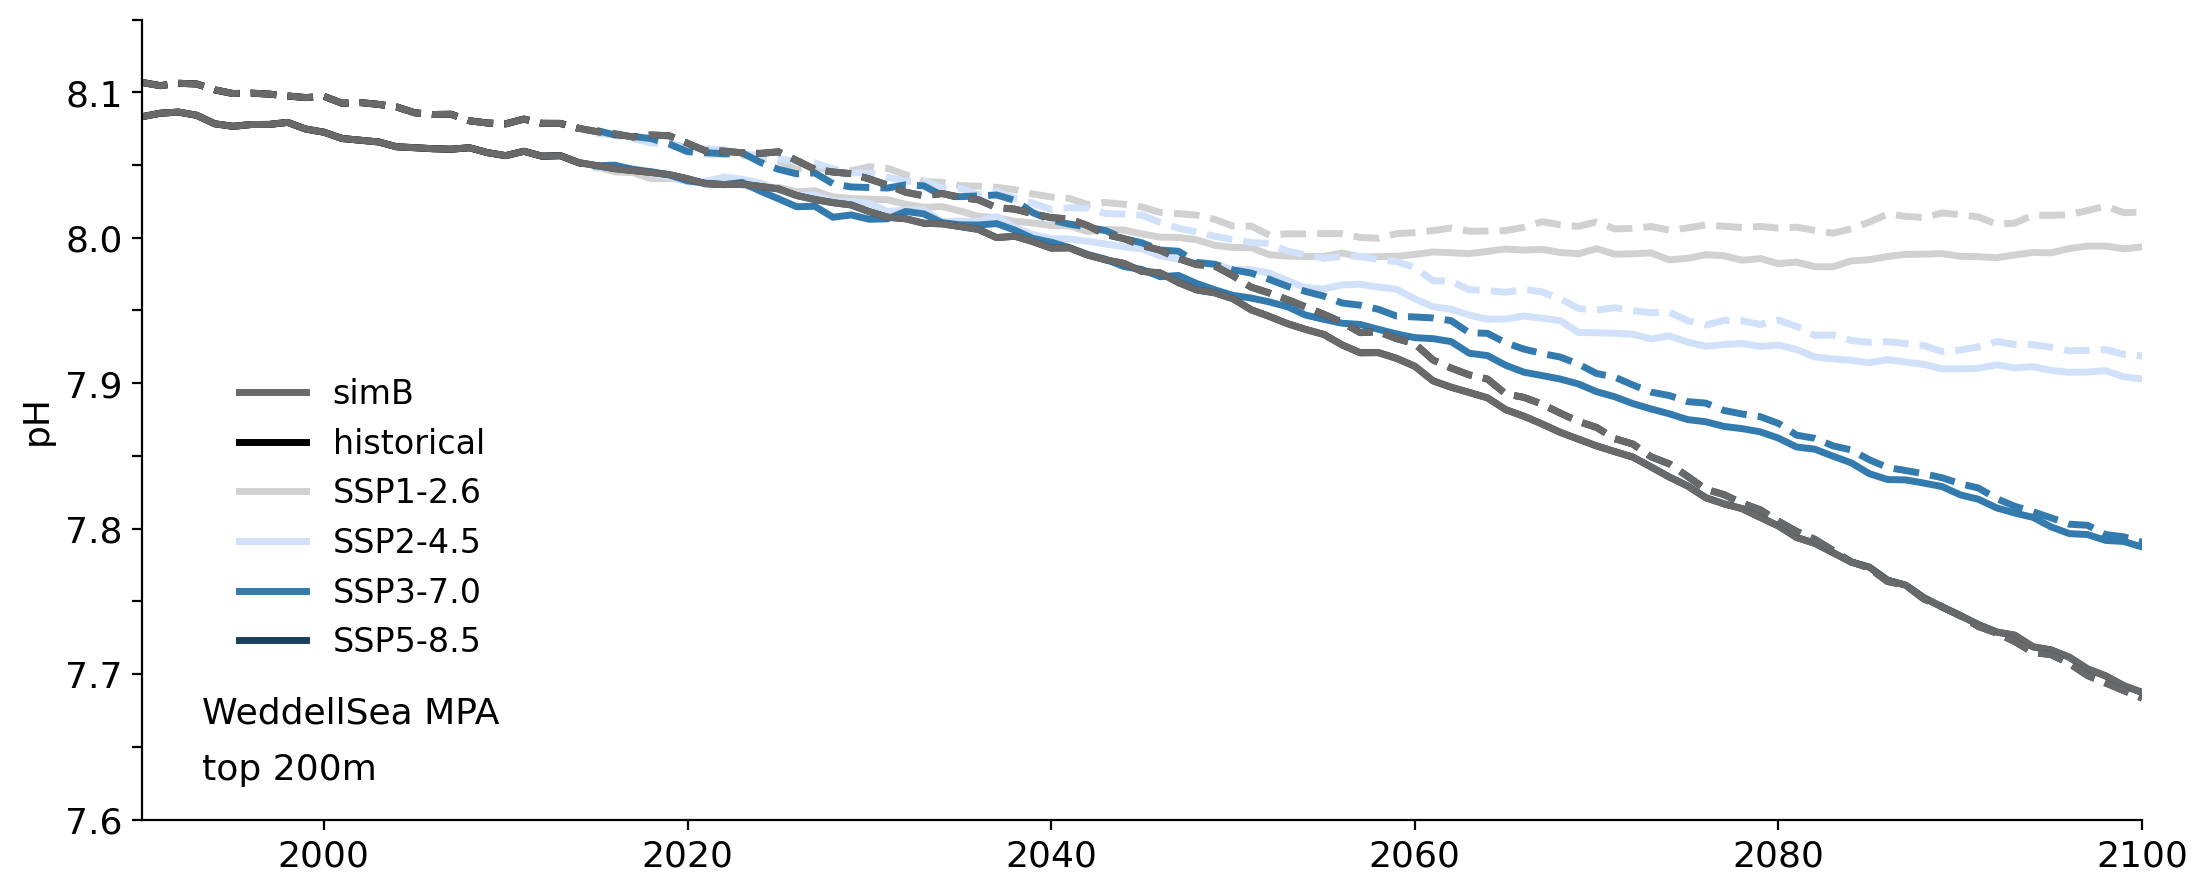

Process  Orkney_MPA top200


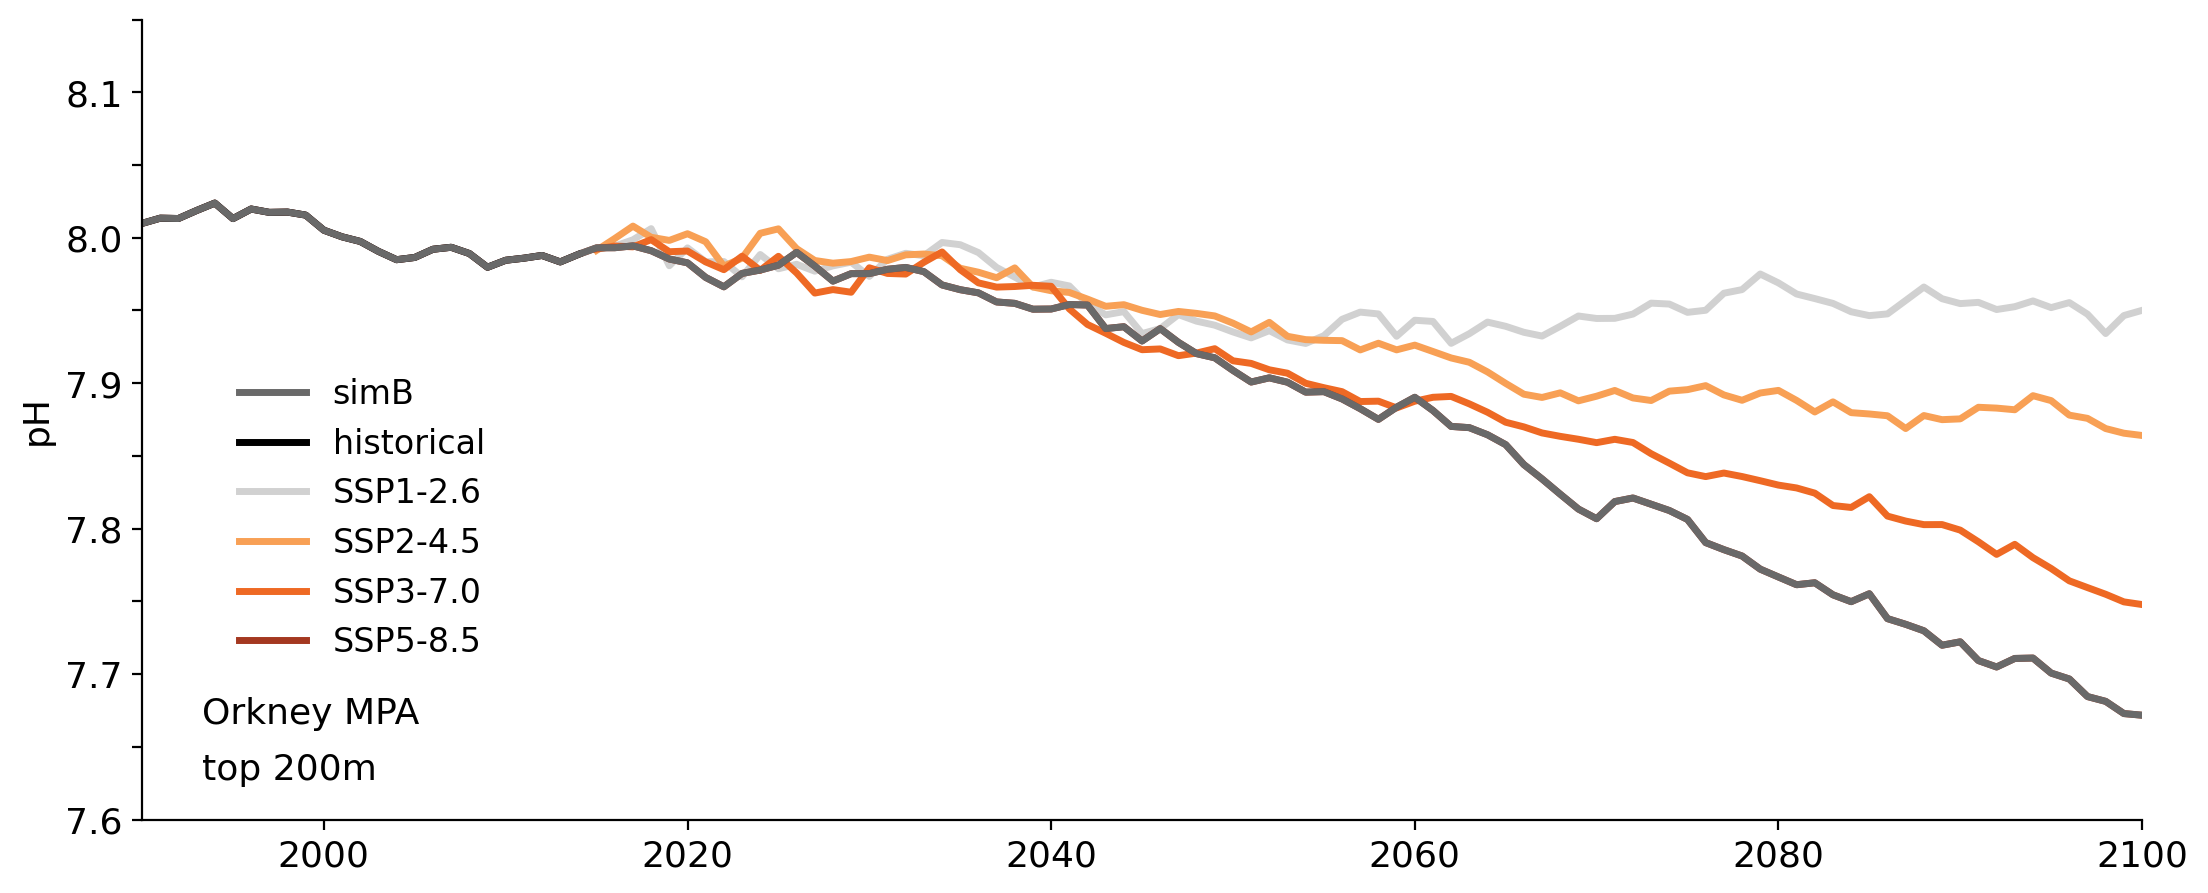

Process  East_Antarctica_all_MPA top200
Also load  East_Antarctica_all_MPA_shelf


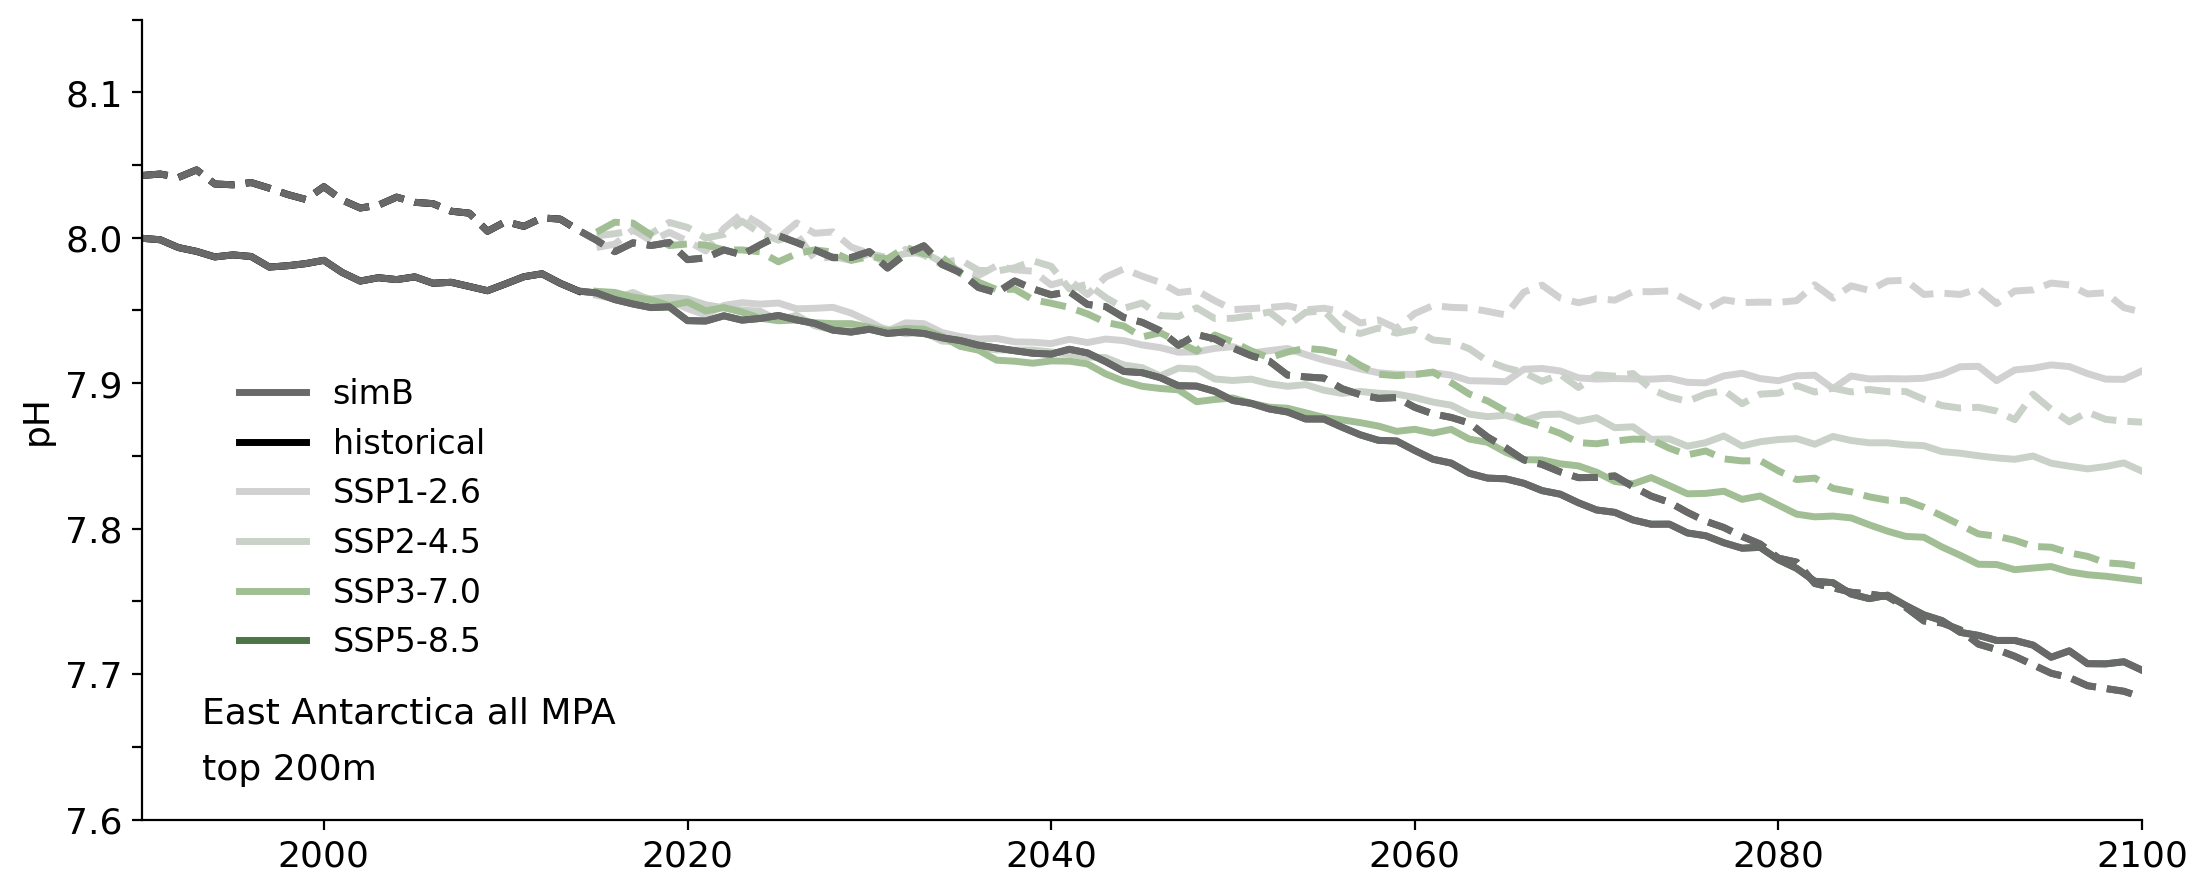

Process  AntarcticPeninsula_MPA top200
Also load  AntarcticPeninsula_MPA_shelf


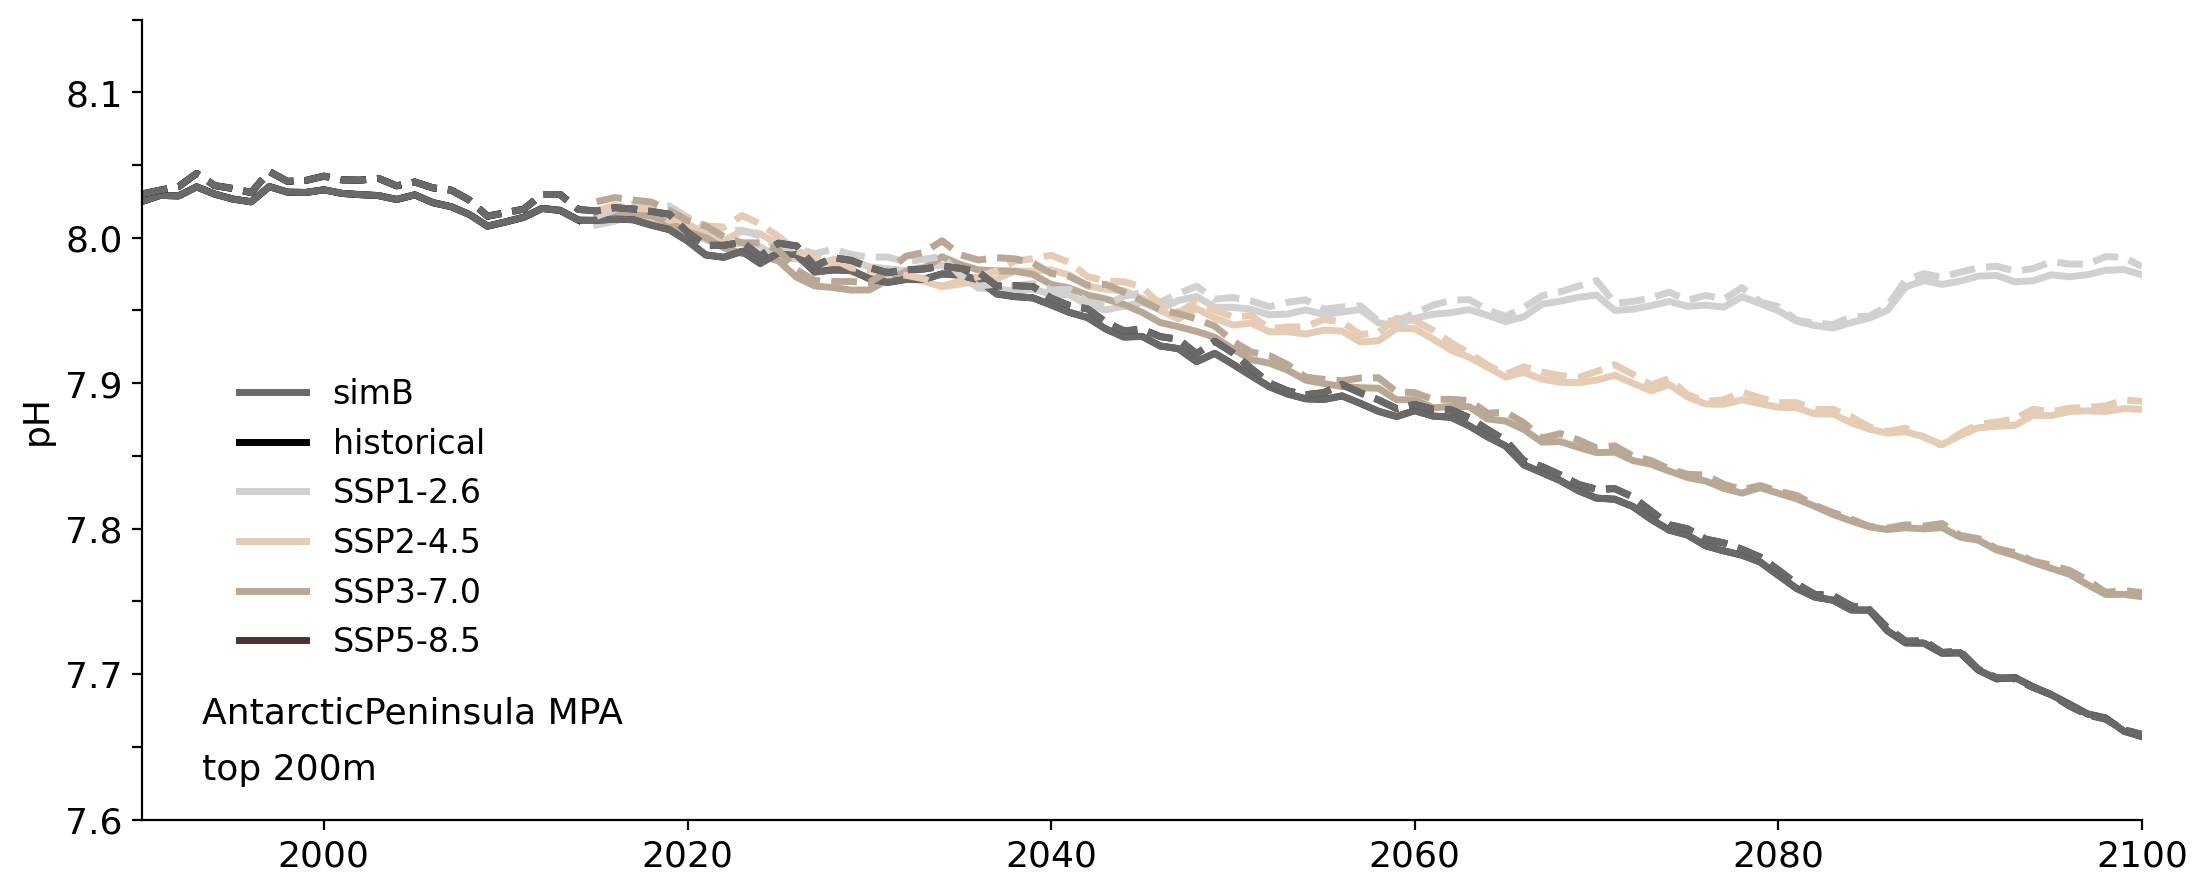

done


In [5]:
#----
# time series of pH
#----

save_plots = False
display_plots = True
plot_eps = False
                
depth_level_list = ['top200','bottom'] 

# list of regions in file
# NOTE: AntarcticPeninsula_MPA_v0 and AntarcticPeninsula_MPA are identical -> was stored twice in *nc files
subregions = ['all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
             'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
              'WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
              'Orkney_MPA','AntarcticPeninsula_MPA_v0',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
              'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_openOcean','East_Antarctica_2_MPA_openOcean',\
              'East_Antarctica_3_MPA_openOcean','East_Antarctica_all_MPA_openOcean',\
             'AntarcticPeninsula_MPA','AntarcticPeninsula_MPA_shelf','AntarcticPeninsula_MPA_openOcean']

subregions_plot = ['WeddellSea_MPA','East_Antarctica_all_MPA','RossSea_MPA','AntarcticPeninsula_MPA','Orkney_MPA']

sim_list = ['ssp585','ssp370','ssp245','ssp126','simB']
sim_list2 = ['SSP5-8.5','SSP3-7.0','SSP2-4.5','SSP1-2.6','simB']

fs = 13
lw = 2.5
dpicnt = 200
            
for dd in range(0,1):#len(depth_level_list)):
    depth_level = depth_level_list[dd] 
    print ('Process ',depth_level)
    
    vari1 = 'pH_avg_'+depth_level  # NOTE: I did not change the name of the array to be plotted further down!!!
    vari2 = 'omegaA_avg_'+depth_level
    dataA_avg,dataC_avg = get_data(vari1,vari2,path_to_data)

    for rr in [8,11,14,19,28]: # HARD-CODED
        if subregions[rr] in subregions_plot: # only continue for the five regions of interest for the paper
            rr = subregions.index(subregions[rr])
            print ('Process ',subregions[rr],depth_level)

            dataA_avg_a = np.mean(dataA_avg[:,:,rr,:],axis=0)

            if subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
                                    'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
                                    'Orkney_MPA','AntarcticPeninsula_MPA',\
                                    'East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']:
                if subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean']:
                    color_list = color_list3
                elif subregions[rr] in ['RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean']:
                    color_list = color_list1
                elif subregions[rr] in ['Orkney_MPA']:
                    color_list = color_list4
                elif subregions[rr] in ['AntarcticPeninsula_MPA']:
                    color_list = color_list5
                elif subregions[rr] in ['East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']:
                    color_list = color_list2
            else:
                color_list = color_list6
            color1 = color_list[0] 
            color2 = color_list[1] 
            color3 = color_list[2] 
            color4 = color_list[3] 

            #---
            # check if shelf region should be loaded
            if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                rr2 = subregions.index(subregions[rr]+'_shelf')
                print ('Also load ',subregions[rr2])

                dataA_avg_a_shelf = np.mean(dataA_avg[:,:,rr2,:],axis=0)
            #-----
            
            print_numbers = False
            if print_numbers:
                #----
                # PRINT SOME NUMBERS
                #----
                print('')
                print('ssp585',subregions[rr],depth_level)
                print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,0]),np.mean(dataA_avg_a[0:9+1,0]),np.mean(dataA_avg_a[100:109+1,0])-np.mean(dataA_avg_a[0:9+1,0]))
                print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,0])),np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,0]))/np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('')
                print('ssp370',subregions[rr],depth_level)
                print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,1]),np.mean(dataA_avg_a[0:9+1,0]),np.mean(dataA_avg_a[100:109+1,1])-np.mean(dataA_avg_a[0:9+1,0]))
                print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,1])),np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,1]))/np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('')
                print('ssp245',subregions[rr],depth_level)
                print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,2]),np.mean(dataA_avg_a[0:9+1,0]),np.mean(dataA_avg_a[100:109+1,2])-np.mean(dataA_avg_a[0:9+1,0]))
                print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,2])),np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,2]))/np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('')
                print('ssp126',subregions[rr],depth_level)
                print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,3]),np.mean(dataA_avg_a[0:9+1,0]),np.mean(dataA_avg_a[100:109+1,3])-np.mean(dataA_avg_a[0:9+1,0]))
                print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,3])),np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,3]))/np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                print('')

                if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                    print('SHELF')
                    print('')
                    print('ssp585/SHELF',subregions[rr],depth_level)
                    print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a_shelf[100:109+1,0]),np.mean(dataA_avg_a_shelf[0:9+1,0]),\
                          np.mean(dataA_avg_a_shelf[100:109+1,0])-np.mean(dataA_avg_a_shelf[0:9+1,0]))
                    print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a_shelf[100:109+1,0])),np.mean(pow(10,-1*dataA_avg_a_shelf[0:9+1,0])))
                    print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a_shelf[100:109+1,0]))/np.mean(pow(10,-1*dataA_avg_a_shelf[0:9+1,0])))
                    print('')
                    print('ssp370/SHELF',subregions[rr],depth_level)
                    print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,1]),np.mean(dataA_avg_a[0:9+1,0]),\
                          np.mean(dataA_avg_a_shelf[100:109+1,1])-np.mean(dataA_avg_a_shelf[0:9+1,0]))
                    print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,1])),np.mean(pow(10,-1*dataA_avg_a_shelf[0:9+1,0])))
                    print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a[100:109+1,1]))/np.mean(pow(10,-1*dataA_avg_a[0:9+1,0])))
                    print('')
                    print('ssp245/SHELF',subregions[rr],depth_level)
                    print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a_shelf[100:109+1,2]),np.mean(dataA_avg_a_shelf[0:9+1,0]),\
                          np.mean(dataA_avg_a_shelf[100:109+1,2])-np.mean(dataA_avg_a_shelf[0:9+1,0]))
                    print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a_shelf[100:109+1,2])),np.mean(pow(10,-1*dataA_avg_a_shelf[0:9+1,0])))
                    print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a_shelf[100:109+1,2]))/np.mean(pow(10,-1*dataA_avg_a_shelf[0:9+1,0])))
                    print('')
                    print('ssp126/SHELF',subregions[rr],depth_level)
                    print('pH change (absolute scale), 2090s, 1990s:',np.mean(dataA_avg_a_shelf[100:109+1,3]),np.mean(dataA_avg_a_shelf[0:9+1,0]),\
                          np.mean(dataA_avg_a_shelf[100:109+1,3])-np.mean(dataA_avg_a_shelf[0:9+1,0]))
                    print('change in H+ concentration, 2090s, 1990s:',np.mean(pow(10,-1*dataA_avg_a_shelf[100:109+1,3])),np.mean(pow(10,-1*dataA_avg_a_shelf[0:9+1,0])))
                    print('ratio H+ 2090s/1990s:',np.mean(pow(10,-1*dataA_avg_a_shelf[100:109+1,3]))/np.mean(pow(10,-1*dataA_avg_a_shelf[0:9+1,0])))
                    print('')


            #---
            # have all scenarios in a single plot
            #---
            plot_combined = True
            if plot_combined:

                years = np.arange(1990,2100+1,1)
                ls = '-'

                fig7= plt.figure(num=18, figsize=(10,4), dpi=dpicnt, facecolor='w', edgecolor='k')
                ax = fig7.add_axes([0, 0, 1, 1])

                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                        
                # ssp585
                ss = 3
                plt.plot(years,dataA_avg_a[:,ss],color=color4,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                
                # ssp370
                ss = 2
                plt.plot(years,dataA_avg_a[:,ss],color=color3,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp245
                ss = 1
                plt.plot(years,dataA_avg_a[:,ss],color=color2,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp126
                ss = 0
                plt.plot(years,dataA_avg_a[:,ss],color=color1,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # historical
                plt.plot(years[0:25],dataA_avg_a[0:25,ss],color='k',linewidth=lw,linestyle=ls,label='historical')

                ss = 4
                plt.plot(years,dataA_avg_a[:,ss],color='dimgrey',linewidth=lw,linestyle=ls,label='simB')

                # plot shelf regions (if applicable)
                if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                    ls = '--'
                    # ssp585
                    ss = 3
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color4,linewidth=lw,linestyle=ls)
                    # ssp370
                    ss = 2
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color3,linewidth=lw,linestyle=ls)
                    # ssp245
                    ss = 1
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color2,linewidth=lw,linestyle=ls)
                    # ssp126
                    ss = 0
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color1,linewidth=lw,linestyle=ls)
                    # historical
                    plt.plot(years[0:25],dataA_avg_a_shelf[0:25,ss],color='k',linewidth=lw,linestyle=ls)
                    ss = 4
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color='dimgrey',linewidth=lw,linestyle=ls)
                    
                    
                handles, labels = plt.gca().get_legend_handles_labels() 
                order = [5,4,0,1,2,3] ##specify order of items in legend

                plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
                           loc='upper center', bbox_to_anchor=(0.11, 0.59),\
                                ncol=1,fancybox=True, frameon=False,shadow=False,prop={'size': 12})

                plt.yticks(fontsize=fs)
                plt.xticks(fontsize=fs)
                plt.xlim((years[0],years[-1]))
                plt.ylabel('pH',fontsize=fs)
                
                plt.ylim((7.6,8.15))
                plt.yticks([7.6,7.65,7.7,7.75,7.8,7.85,7.9,7.95,8.0,8.05,8.1,8.15],[7.6,'',7.7,'',7.8,'',7.9,'',8.0,'',8.1,''],fontsize=fs)

                plt.annotate(subregions[rr].replace("_"," "),xy=(0.03,0.12), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')

                if depth_level in ['water_column']:
                    plt.annotate('whole water column',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['0_10']:
                    plt.annotate('0-10m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['10_100']:
                    plt.annotate('10-100m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['100_500']:
                    plt.annotate('100-500m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['below500']:
                    plt.annotate('below 500m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['bottom']:
                    plt.annotate('bottom',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['top200']:
                    plt.annotate('top 200m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')

                if save_plots:
                    filename = 'TimeSeries_pH_FOR_PAPER_ALL_SIM_'+subregions[rr]+'_'+depth_level+'.png'
                    plt.savefig(savepath1+filename,dpi = dpicnt, bbox_inches='tight',format='png')
                    del filename

                if display_plots:
                    plt.show()
                else:
                    plt.close(fig7)
                    
                    
                #----
                # plot eps
                #----
                if plot_eps:
                    fig7= plt.figure(num=18, figsize=(10,4), dpi=dpicnt, facecolor='w', edgecolor='k')
                    ax = fig7.add_axes([0, 0, 1, 1])
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ls = '-'
                    # ssp585
                    plt.plot(years,dataA_avg_a[:,3],color=color4,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp370
                    plt.plot(years,dataA_avg_a[:,2],color=color3,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp245
                    plt.plot(years,dataA_avg_a[:,1],color=color2,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp126
                    plt.plot(years,dataA_avg_a[:,0],color=color1,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # historical
                    plt.plot(years[0:25],dataA_avg_a[0:25,0],color='k',linewidth=lw,linestyle=ls,label='historical')

                    plt.plot(years,dataA_avg_a[:,4],color='dimgrey',linewidth=lw,linestyle=ls,label='simB')

                    # plot shelf regions (if applicable)
                    if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                        ls = '--'
                        # ssp585
                        plt.plot(years,dataA_avg_a_shelf[:,3],color=color4,linewidth=lw,linestyle=ls)
                        # ssp370
                        plt.plot(years,dataA_avg_a_shelf[:,2],color=color3,linewidth=lw,linestyle=ls)
                        # ssp245
                        plt.plot(years,dataA_avg_a_shelf[:,1],color=color2,linewidth=lw,linestyle=ls)
                        # ssp126
                        plt.plot(years,dataA_avg_a_shelf[:,0],color=color1,linewidth=lw,linestyle=ls)
                        # historical
                        plt.plot(years[0:25],dataA_avg_a_shelf[0:25,0],color='k',linewidth=lw,linestyle=ls)
                        plt.plot(years,dataA_avg_a_shelf[:,4],color='dimgrey',linewidth=lw,linestyle=ls)

                    plt.yticks(fontsize=fs)
                    plt.xticks(fontsize=fs)
                    plt.xlim((years[0],years[-1]))
                    plt.xticks([2000,2020,2040,2060,2080,2100],[],fontsize=fs)
                
                    plt.ylim((7.6,8.15))
                    plt.yticks([7.6,7.65,7.7,7.75,7.8,7.85,7.9,7.95,8.0,8.05,8.1,8.15],[],fontsize=fs)

                    if save_plots:
                        filename = 'TimeSeries_pH_FOR_PAPER_ALL_SIM_'+subregions[rr]+'_'+depth_level+'.eps'
                        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
                        del filename

                    if display_plots:
                        plt.show()
                    else:
                        plt.close(fig7)

           # del dataA_avg_a
            
print ('done')


In [6]:
#---
# get linear trends for bottom pH for two periods
# high-emission scenario
#----

aux1 = dataA_avg_a_shelf[:,0]
aux1[0:25] = dataA_avg_a_shelf[0:25,0] # add historical to data
aux1 = np.array(aux1)

# define start years for the two trend periods
ind_start = 50
ind_t = 96

print('Decadal trends in bottom pH between the following years:',years[ind_start],years[ind_t])

#---
# SHELF
#---
print()
print('shelf')
print()
# until 2085
x = np.array(np.arange(0,len(aux1[ind_start:ind_t])))
x1 = x.reshape((-1, 1))
#print(x1.shape,aux1[0:ind_t].shape)
model = LinearRegression()
model.fit(x1, aux1[ind_start:ind_t])
model = LinearRegression().fit(x1, aux1[ind_start:ind_t])
trend1 = 10*model.coef_[0]
print('Linear trend before '+str(years[ind_t])+' (ssp585): '+str(trend1))
# after 2085
x = np.array(np.arange(0,len(aux1[ind_t:])))
x1 = x.reshape((-1, 1))
#print(x1.shape,aux1[ind_t:].shape)
#print(aux1[ind_t:])
model = LinearRegression()
model.fit(x1, aux1[ind_t:])
model = LinearRegression().fit(x1, aux1[ind_t:])
trend2 = 10*model.coef_[0]
print('Linear trend from '+str(years[ind_t])+' onwards (ssp585): '+str(trend2))
print('Ratio:',trend2/trend1)



#---
# whole MPA
#---
print()
print('whole MPA')
print()

aux1 = dataA_avg_a[:,0]
aux1[0:25] = dataA_avg_a[0:25,0] # add historical to data
aux1 = np.array(aux1)

# until 2085
x = np.array(np.arange(0,len(aux1[ind_start:ind_t])))
x1 = x.reshape((-1, 1))
#print(x1.shape,aux1[0:ind_t].shape)
model = LinearRegression()
model.fit(x1, aux1[ind_start:ind_t])
model = LinearRegression().fit(x1, aux1[ind_start:ind_t])
trend1 = 10*model.coef_[0]
print('Linear trend before '+str(years[ind_t])+' (ssp585): '+str(trend1))
# after 2085
x = np.array(np.arange(0,len(aux1[ind_t:])))
x1 = x.reshape((-1, 1))
#print(x1.shape,aux1[ind_t:].shape)
#print(aux1[ind_t:])
model = LinearRegression()
model.fit(x1, aux1[ind_t:])
model = LinearRegression().fit(x1, aux1[ind_t:])
trend2 = 10*model.coef_[0]
print('Linear trend from '+str(years[ind_t])+' onwards (ssp585): '+str(trend2))
print('Ratio:',trend2/trend1)


Decadal trends in bottom pH between the following years: 2040 2086

shelf

Linear trend before 2086 (ssp585): -0.04700639216281585
Linear trend from 2086 onwards (ssp585): -0.05259664143834782
Ratio: 1.1189252996947532

whole MPA

Linear trend before 2086 (ssp585): -0.046479990529136726
Linear trend from 2086 onwards (ssp585): -0.05152392387390126
Ratio: 1.1085183815087627


Process  top200
Load  omegaA_avg_top200 omegaC_avg_top200
data_all_Arag.shape (months x years x regions x simulations): (12, 111, 31, 5)
Process  RossSea_MPA
Also load  RossSea_MPA_shelf


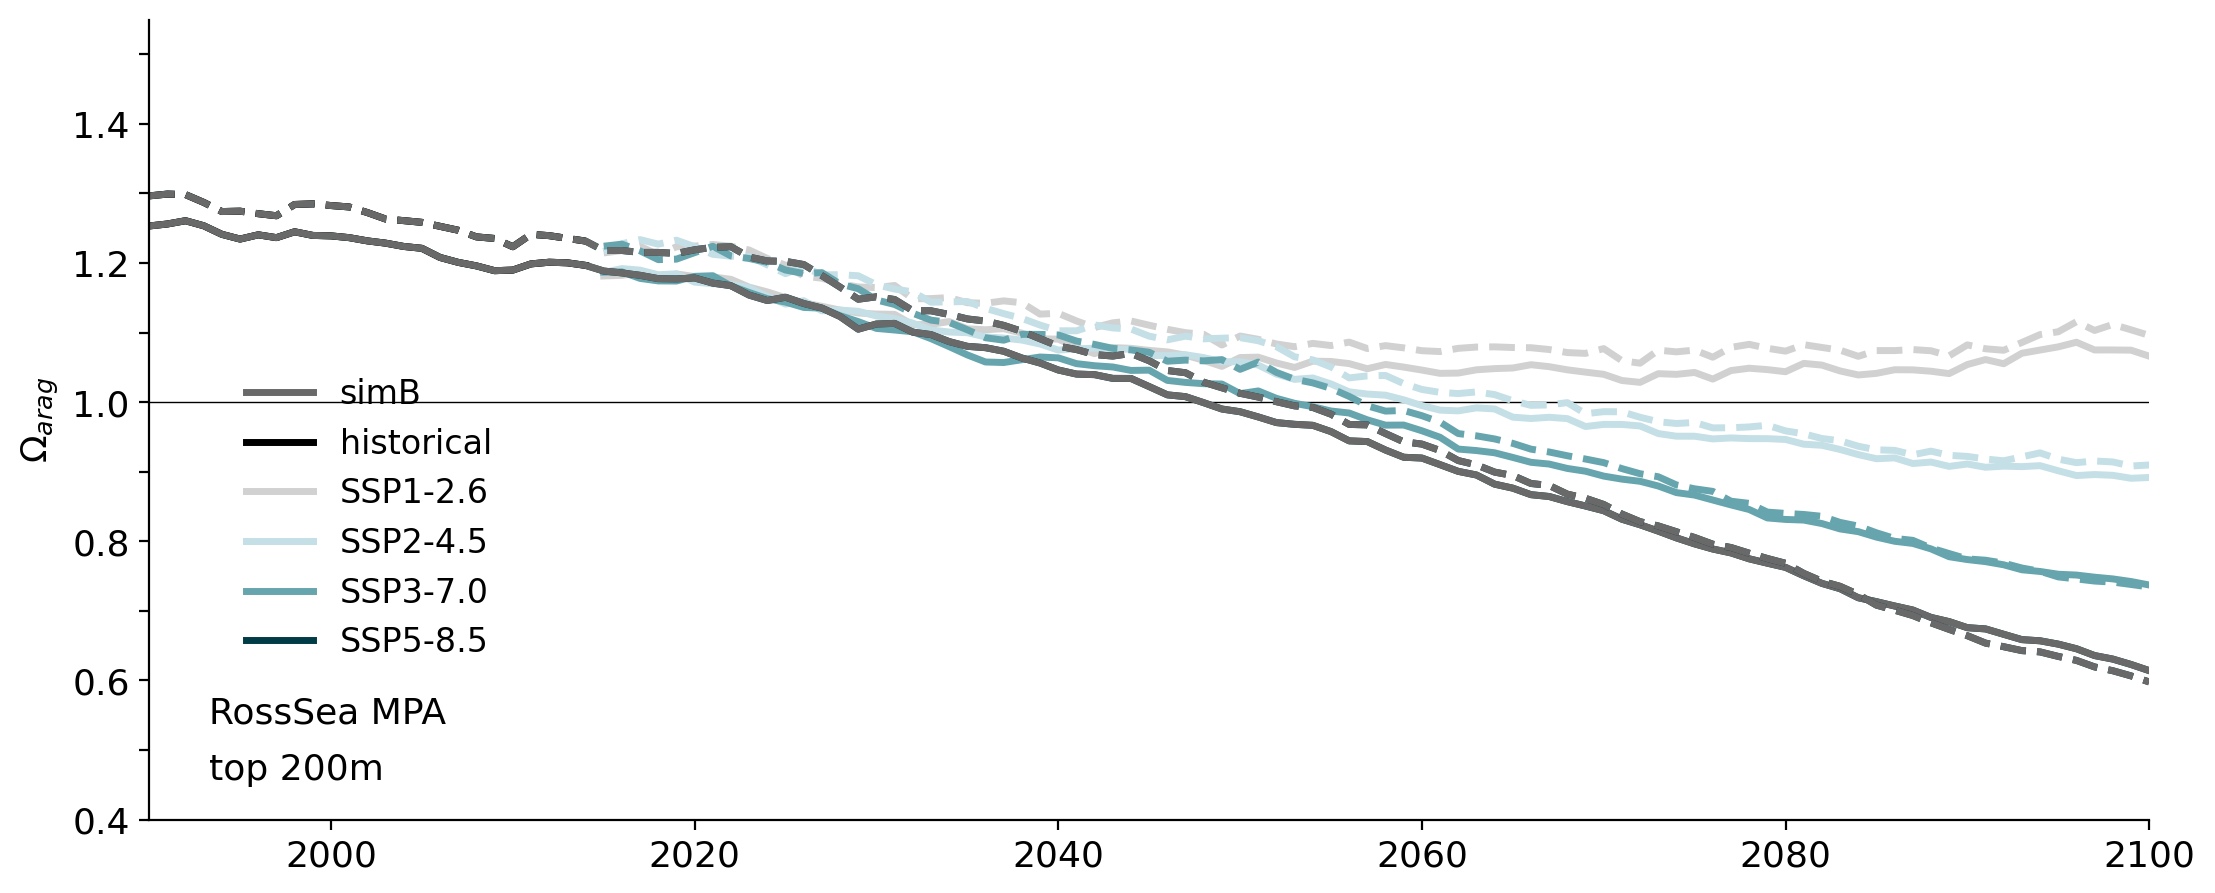

Process  WeddellSea_MPA
Also load  WeddellSea_MPA_shelf


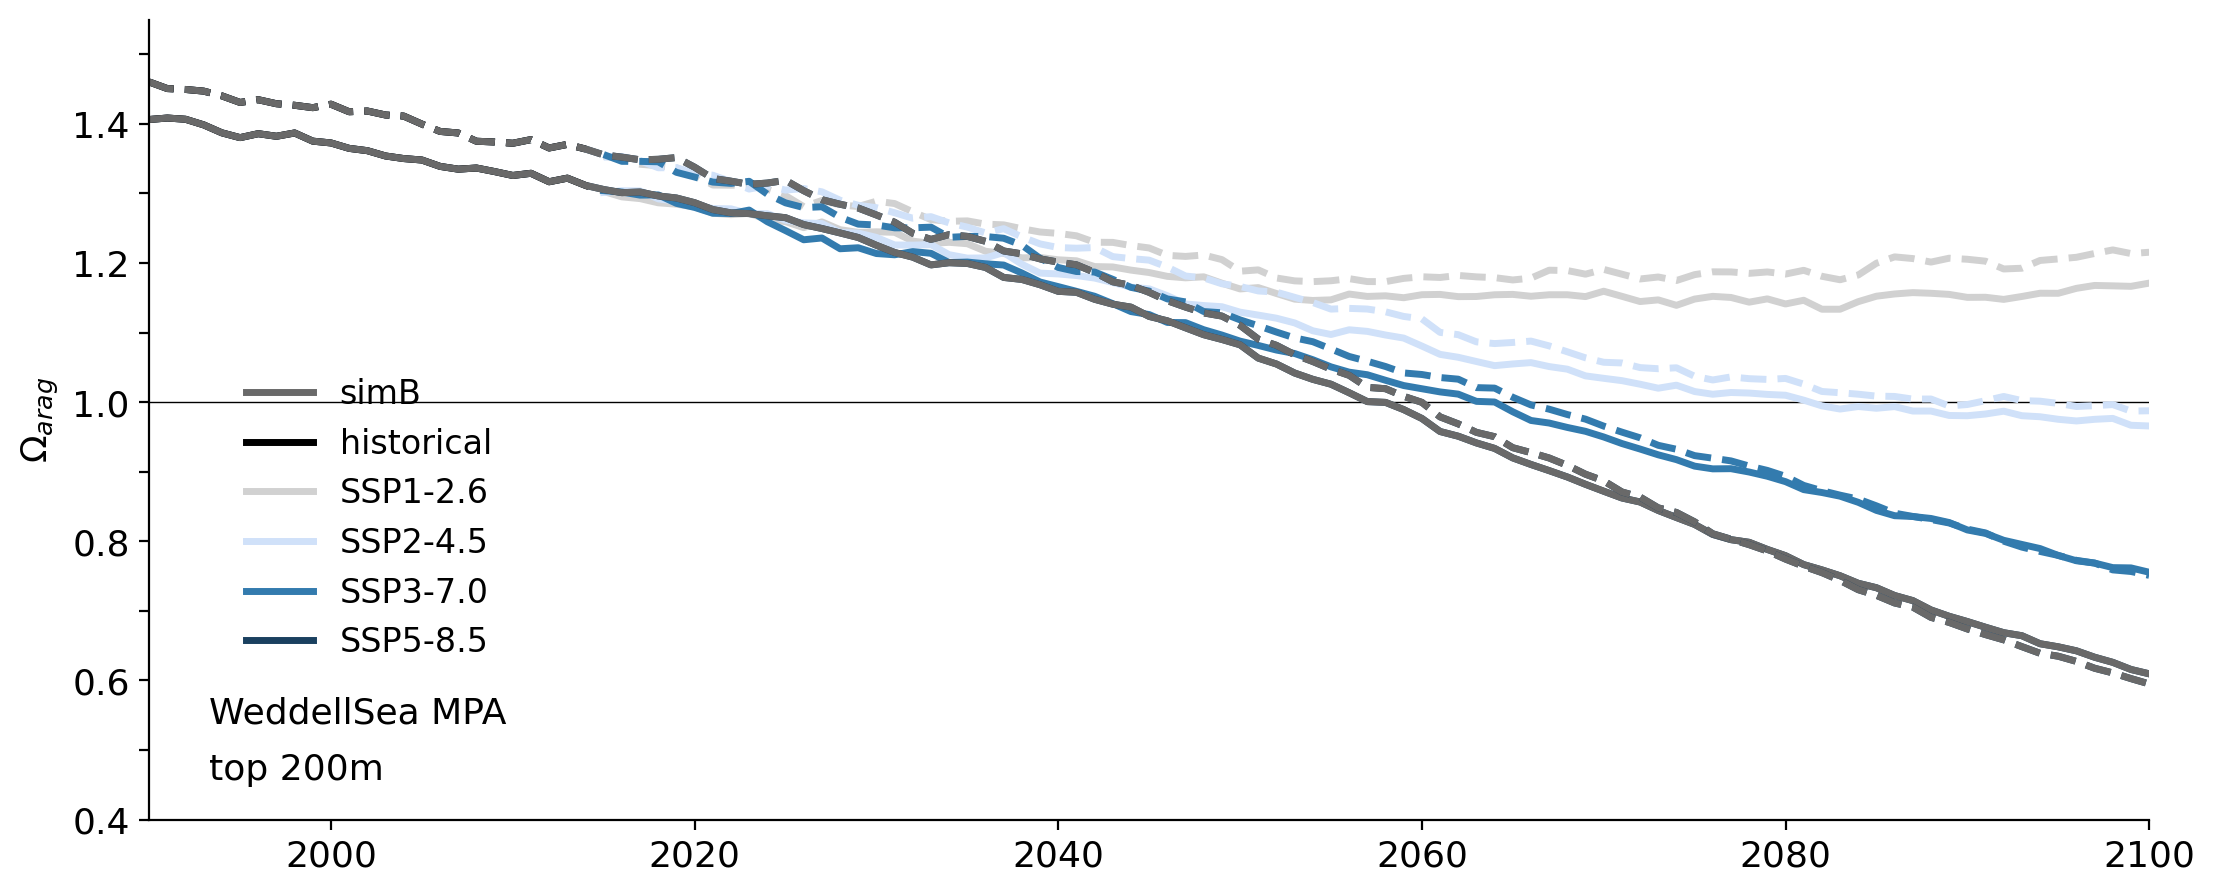

Process  Orkney_MPA


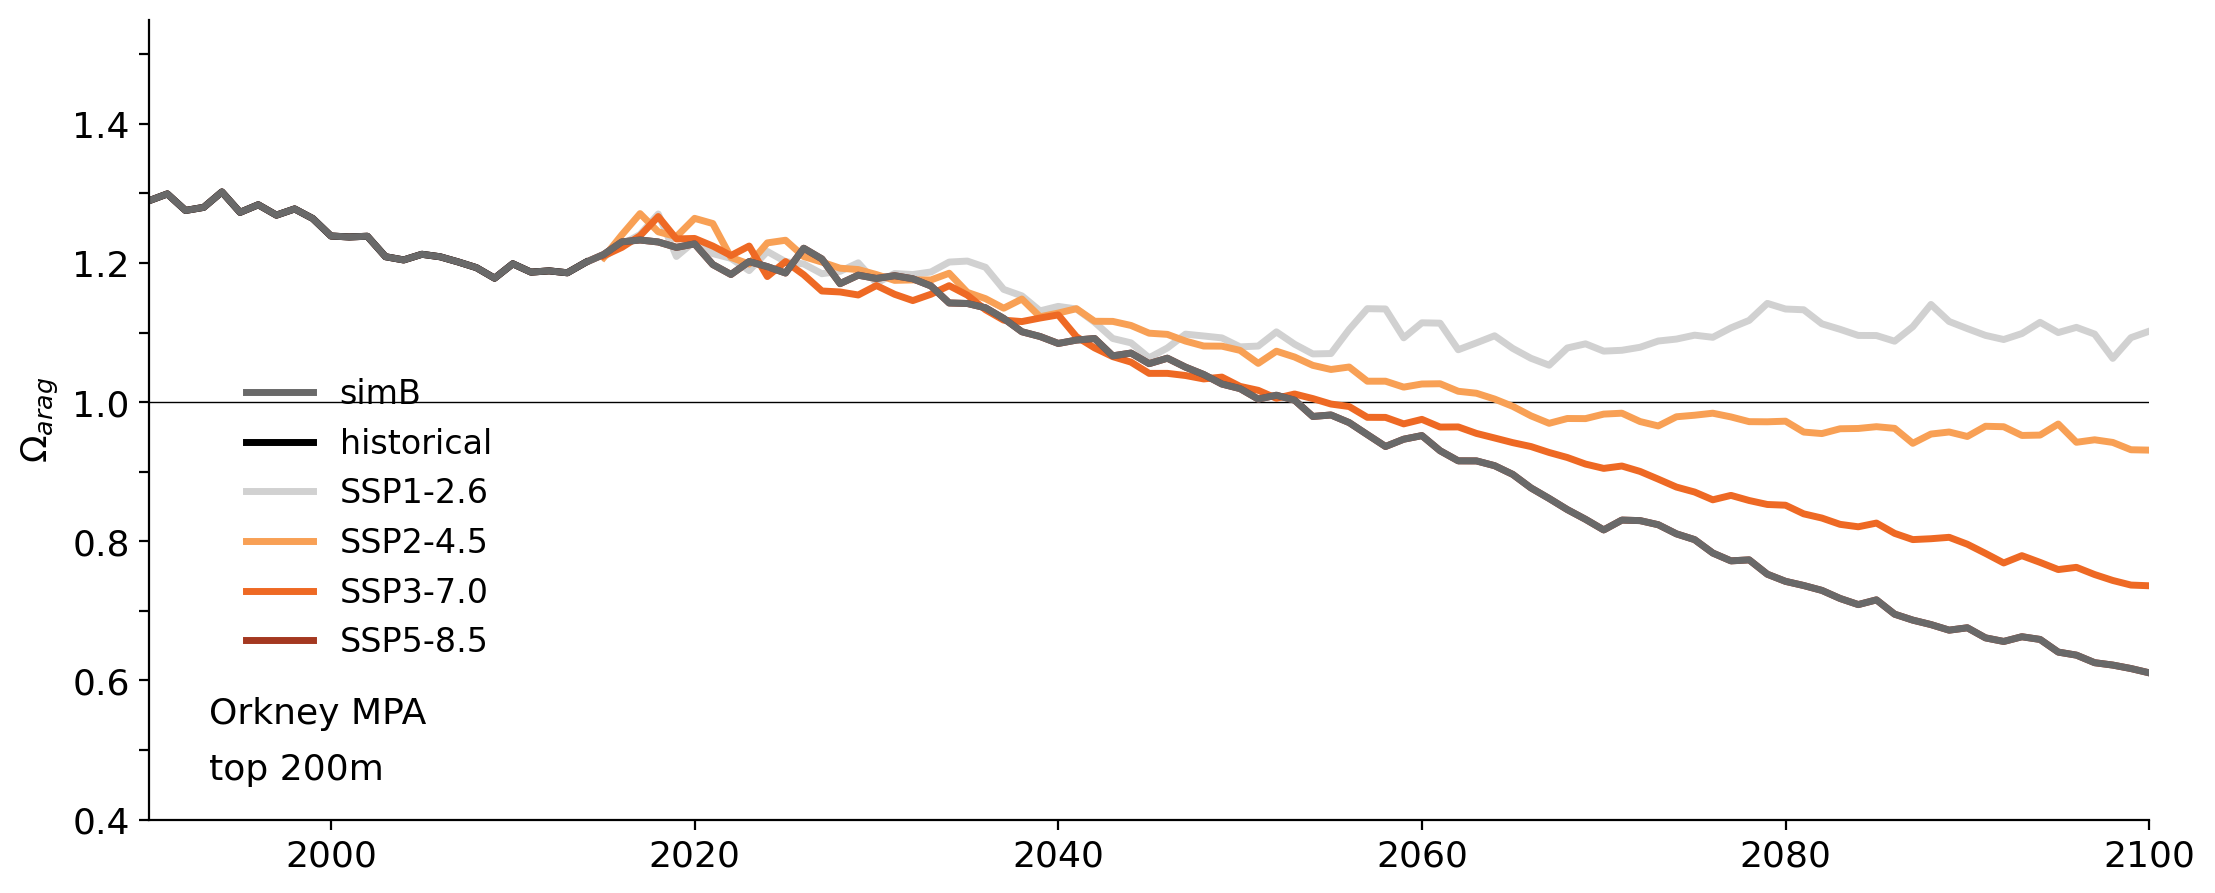

Process  East_Antarctica_all_MPA
Also load  East_Antarctica_all_MPA_shelf


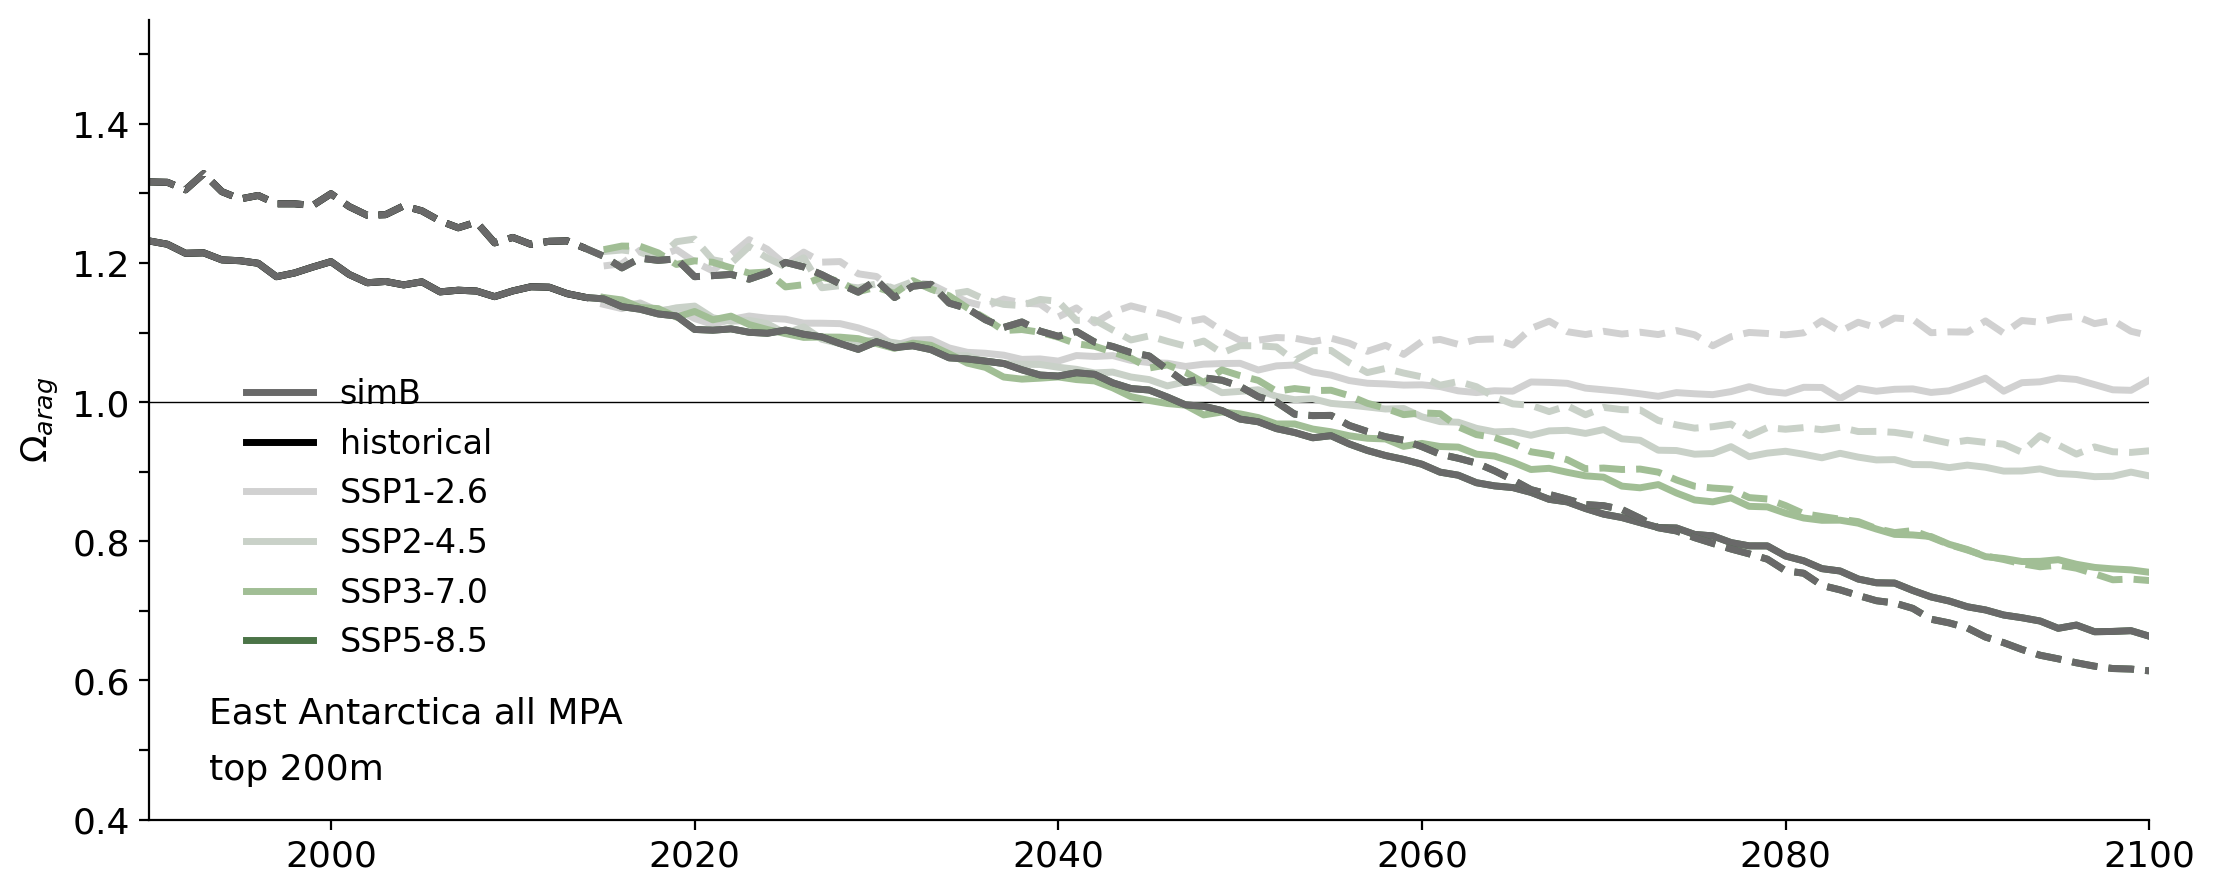

Process  AntarcticPeninsula_MPA
Also load  AntarcticPeninsula_MPA_shelf


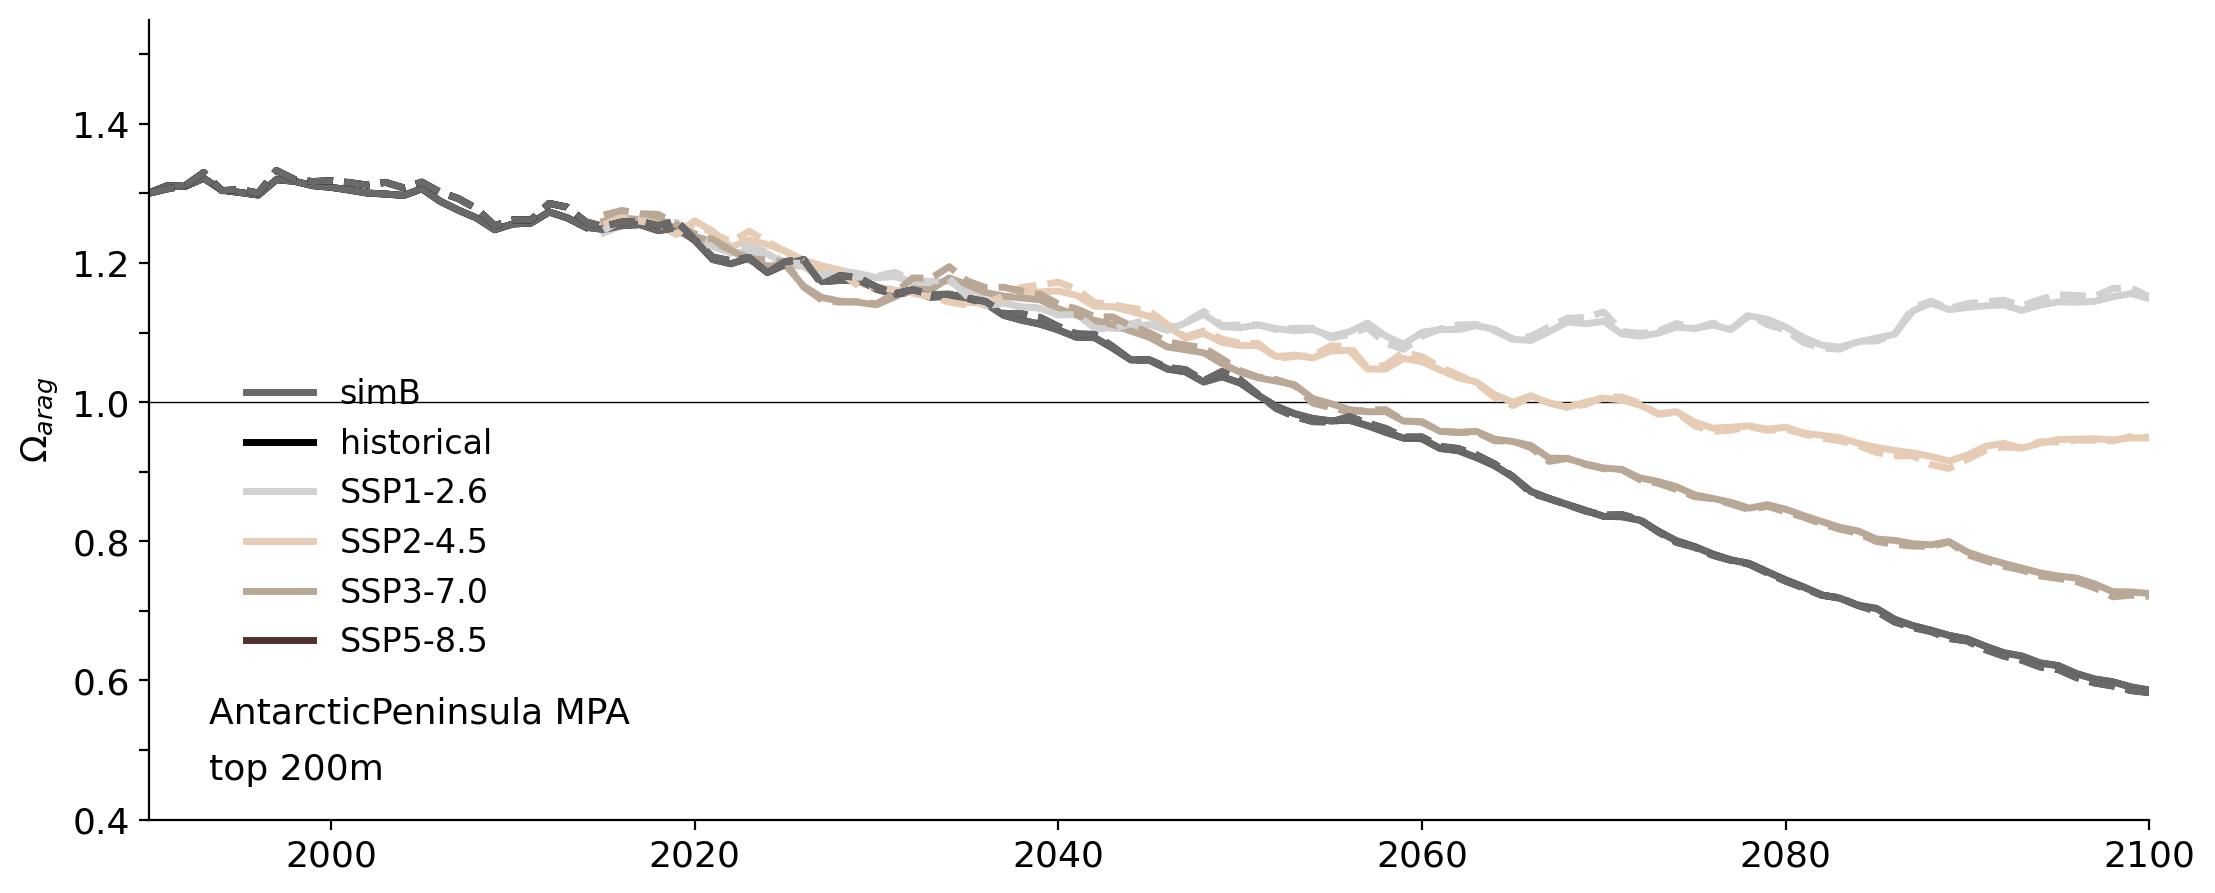

done


In [7]:
#----
# time series of omegaA (not in paper)
#----

save_plots = False
display_plots = True
plot_eps = False

depth_level_list = ['top200','bottom'] 

# list of regions in file
# NOTE: AntarcticPeninsula_MPA_v0 and AntarcticPeninsula_MPA are identical -> was stored twice in *nc files
subregions = ['all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
             'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
              'WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
              'Orkney_MPA','AntarcticPeninsula_MPA_v0',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
              'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_openOcean','East_Antarctica_2_MPA_openOcean',\
              'East_Antarctica_3_MPA_openOcean','East_Antarctica_all_MPA_openOcean',\
             'AntarcticPeninsula_MPA','AntarcticPeninsula_MPA_shelf','AntarcticPeninsula_MPA_openOcean']

subregions_plot = ['WeddellSea_MPA','East_Antarctica_all_MPA','RossSea_MPA','AntarcticPeninsula_MPA','Orkney_MPA']

sim_list = ['ssp585','ssp370','ssp245','ssp126','simB']
sim_list2 = ['SSP5-8.5','SSP3-7.0','SSP2-4.5','SSP1-2.6','simB']

fs = 13
lw = 2.5
dpicnt = 200
            
for dd in range(0,1):#len(depth_level_list)):
    depth_level = depth_level_list[dd] 
    print ('Process ',depth_level)
    
    vari1 = 'omegaA_avg_'+depth_level  
    vari2 = 'omegaC_avg_'+depth_level
    dataA_avg,dataC_avg = get_data(vari1,vari2,path_to_data)

    for rr in [8,11,14,19,28]: # HARD-CODED
        if subregions[rr] in subregions_plot: # only continue for the five regions of interest for the paper
            rr = subregions.index(subregions[rr])
            print ('Process ',subregions[rr])

            dataA_avg_a = np.mean(dataA_avg[:,:,rr,:],axis=0)

            if subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
                                    'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
                                    'Orkney_MPA','AntarcticPeninsula_MPA',\
                                    'East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']:
                if subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean']:
                    color_list = color_list3
                elif subregions[rr] in ['RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean']:
                    color_list = color_list1
                elif subregions[rr] in ['Orkney_MPA']:
                    color_list = color_list4
                elif subregions[rr] in ['AntarcticPeninsula_MPA']:
                    color_list = color_list5
                elif subregions[rr] in ['East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']:
                    color_list = color_list2
            else:
                color_list = color_list6
                
            color1 = color_list[0] 
            color2 = color_list[1] 
            color3 = color_list[2] 
            color4 = color_list[3] 

            #---
            # check if shelf region should be loaded
            if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                rr2 = subregions.index(subregions[rr]+'_shelf')
                print ('Also load ',subregions[rr2])

                dataA_avg_a_shelf = np.mean(dataA_avg[:,:,rr2,:],axis=0)
            #-----

            print_numbers = False
            if print_numbers:
                #----
                # PRINT SOME NUMBERS
                #----
                print('')
                print('ssp585',subregions[rr],depth_level)
                print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,0]),np.mean(dataA_avg_a[0:9+1,0]))
                print('')
                print('ssp370',subregions[rr],depth_level)
                print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,1]),np.mean(dataA_avg_a[0:9+1,0]))
                print('')
                print('ssp245',subregions[rr],depth_level)
                print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,2]),np.mean(dataA_avg_a[0:9+1,0]))
                print('')
                print('ssp126',subregions[rr],depth_level)
                print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,3]),np.mean(dataA_avg_a[0:9+1,0]))
                print('')

                if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                    print('SHELF')
                    print('')
                    print('ssp585/SHELF',subregions[rr],depth_level)
                    print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a_shelf[100:109+1,0]),np.mean(dataA_avg_a_shelf[0:9+1,0]))
                    print('')
                    print('ssp370/SHELF',subregions[rr],depth_level)
                    print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a[100:109+1,1]),np.mean(dataA_avg_a[0:9+1,0]))
                    print('')
                    print('ssp245/SHELF',subregions[rr],depth_level)
                    print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a_shelf[100:109+1,2]),np.mean(dataA_avg_a_shelf[0:9+1,0]))
                    print('')
                    print('ssp126/SHELF',subregions[rr],depth_level)
                    print('omegaA change, 2090s, 1990s:',np.mean(dataA_avg_a_shelf[100:109+1,3]),np.mean(dataA_avg_a_shelf[0:9+1,0]))
                    print('')
                    
                    
            #---
            # have all scenarios in a single plot
            #---
            plot_combined = True
            if plot_combined:

                years = np.arange(1990,2100+1,1)
                
                fig7= plt.figure(num=18, figsize=(10,4), dpi=dpicnt, facecolor='w', edgecolor='k')
                ax = fig7.add_axes([0, 0, 1, 1])

                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                #ax.spines['bottom'].set_visible(False)
                #ax.spines['left'].set_visible(False)

                plt.hlines(1,years[0],years[-1],color='black',linewidth=0.5)

                ls = '-'
                # ssp585
                ss = 3
                plt.plot(years,dataA_avg_a[:,ss],color=color4,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp370
                ss = 2
                plt.plot(years,dataA_avg_a[:,ss],color=color3,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp245
                ss = 1
                plt.plot(years,dataA_avg_a[:,ss],color=color2,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp126
                ss = 0
                plt.plot(years,dataA_avg_a[:,ss],color=color1,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # historical
                plt.plot(years[0:25],dataA_avg_a[0:25,ss],color='k',linewidth=lw,linestyle=ls,label='historical')

                ss = 4
                plt.plot(years,dataA_avg_a[:,ss],color='dimgrey',linewidth=lw,linestyle=ls,label='simB')

                # plot shelf regions (if applicable)
                if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                    ls = '--'
                    # ssp585
                    ss = 3
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color4,linewidth=lw,linestyle=ls)
                    # ssp370
                    ss = 2
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color3,linewidth=lw,linestyle=ls)
                    # ssp245
                    ss = 1
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color2,linewidth=lw,linestyle=ls)
                    # ssp126
                    ss = 0
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color=color1,linewidth=lw,linestyle=ls)
                    # historical
                    plt.plot(years[0:25],dataA_avg_a_shelf[0:25,ss],color='k',linewidth=lw,linestyle=ls)
                    ss = 4
                    plt.plot(years,dataA_avg_a_shelf[:,ss],color='dimgrey',linewidth=lw,linestyle=ls)
                    
                    
                handles, labels = plt.gca().get_legend_handles_labels() 
                order = [5,4,0,1,2,3] ##specify order of items in legend

                plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
                           loc='upper center', bbox_to_anchor=(0.11, 0.59),\
                                ncol=1,fancybox=True, frameon=False,shadow=False,prop={'size': 12})

                plt.yticks(fontsize=fs)
                plt.xticks(fontsize=fs)
                plt.xlim((years[0],years[-1]))
                plt.ylabel('$\Omega_{arag}$',fontsize=fs)
                
                plt.ylim((0.4,1.55))
                plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5],[0.4,'',0.6,'',0.8,'',1.0,'',1.2,'',1.4,''],fontsize=fs)

                plt.annotate(subregions[rr].replace("_"," "),xy=(0.03,0.12), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')

                if depth_level in ['water_column']:
                    plt.annotate('whole water column',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['0_10']:
                    plt.annotate('0-10m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['10_100']:
                    plt.annotate('10-100m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['100_500']:
                    plt.annotate('100-500m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['below500']:
                    plt.annotate('below 500m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['bottom']:
                    plt.annotate('bottom',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['top200']:
                    plt.annotate('top 200m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')

                if save_plots:
                    filename = 'TimeSeries_omegaA_FOR_PAPER_ALL_SIM_'+subregions[rr]+'_'+depth_level+'.png'
                    plt.savefig(savepath1+filename,dpi = dpicnt, bbox_inches='tight',format='png')
                    del filename

                if display_plots:
                    plt.show()
                else:
                    plt.close(fig7)
                    
                    
                #----
                # plot eps
                #----
                if plot_eps:
                    fig7= plt.figure(num=18, figsize=(10,4), dpi=dpicnt, facecolor='w', edgecolor='k')
                    ax = fig7.add_axes([0, 0, 1, 1])
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    plt.hlines(1,years[0],years[-1],color='black',linewidth=0.5)
                    ls = '-'
                    # ssp585
                    plt.plot(years,dataA_avg_a[:,3],color=color4,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp370
                    plt.plot(years,dataA_avg_a[:,2],color=color3,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp245
                    plt.plot(years,dataA_avg_a[:,1],color=color2,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp126
                    plt.plot(years,dataA_avg_a[:,0],color=color1,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # historical
                    plt.plot(years[0:25],dataA_avg_a[0:25,0],color='k',linewidth=lw,linestyle=ls,label='historical')

                    plt.plot(years,dataA_avg_a[:,4],color='dimgrey',linewidth=lw,linestyle=ls,label='simB')

                    # plot shelf regions (if applicable)
                    if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                        ls = '--'
                        # ssp585
                        plt.plot(years,dataA_avg_a_shelf[:,3],color=color4,linewidth=lw,linestyle=ls)
                        # ssp370
                        plt.plot(years,dataA_avg_a_shelf[:,2],color=color3,linewidth=lw,linestyle=ls)
                        # ssp245
                        plt.plot(years,dataA_avg_a_shelf[:,1],color=color2,linewidth=lw,linestyle=ls)
                        # ssp126
                        plt.plot(years,dataA_avg_a_shelf[:,0],color=color1,linewidth=lw,linestyle=ls)
                        # historical
                        plt.plot(years[0:25],dataA_avg_a_shelf[0:25,0],color='k',linewidth=lw,linestyle=ls)
                        plt.plot(years,dataA_avg_a_shelf[:,4],color='dimgrey',linewidth=lw,linestyle=ls)

                    plt.yticks(fontsize=fs)
                    plt.xticks(fontsize=fs)
                    plt.xlim((years[0],years[-1]))
                    plt.xticks([2000,2020,2040,2060,2080,2100],[],fontsize=fs)
                    
                    plt.ylim((0.4,1.55))
                    plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5],[],fontsize=fs)

                    if save_plots:
                        filename = 'TimeSeries_omegaA_FOR_PAPER_ALL_SIM_'+subregions[rr]+'_'+depth_level+'.eps'
                        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
                        del filename

                    if display_plots:
                        plt.show()
                    else:
                        plt.close(fig7)

            del dataA_avg_a
            
print ('done')




Process  top200
Load  omegaA_avg_top200 omegaC_avg_top200
data_all_Arag.shape (months x years x regions x simulations): (12, 111, 31, 5)
Process  RossSea_MPA
Also load  RossSea_MPA_shelf


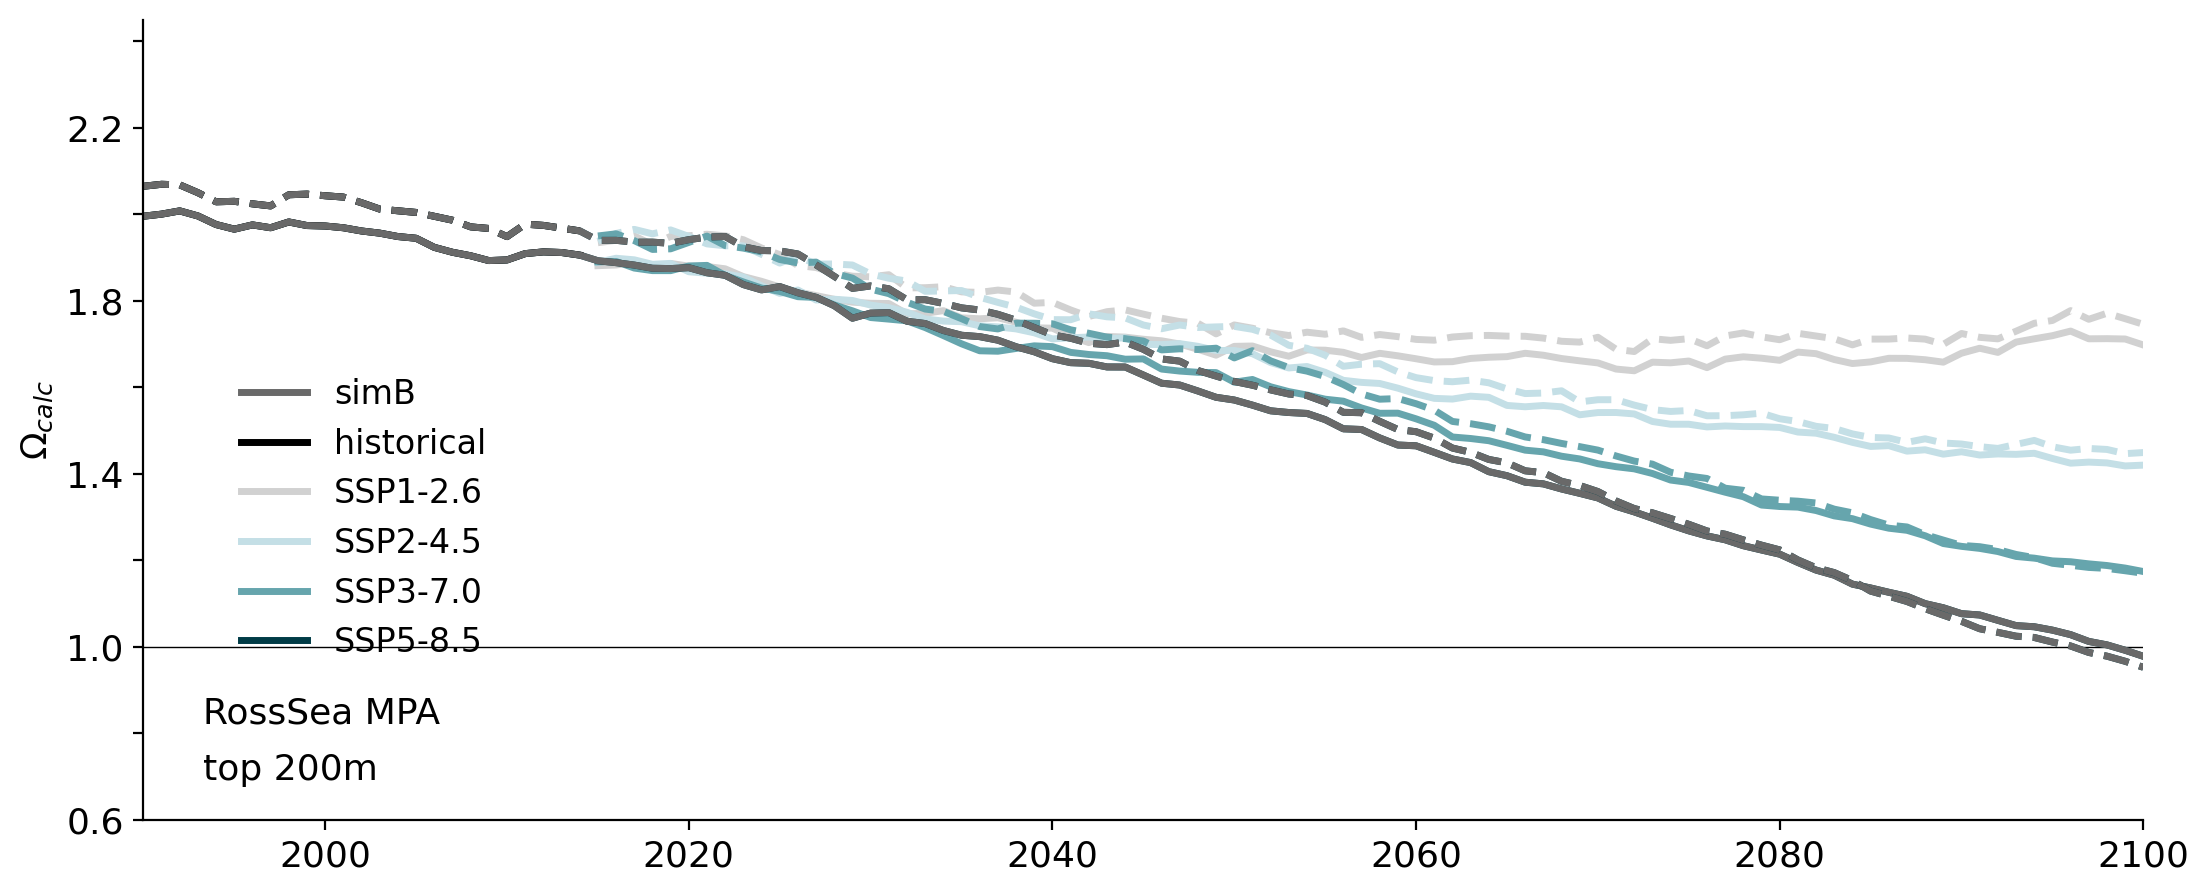

Process  WeddellSea_MPA
Also load  WeddellSea_MPA_shelf


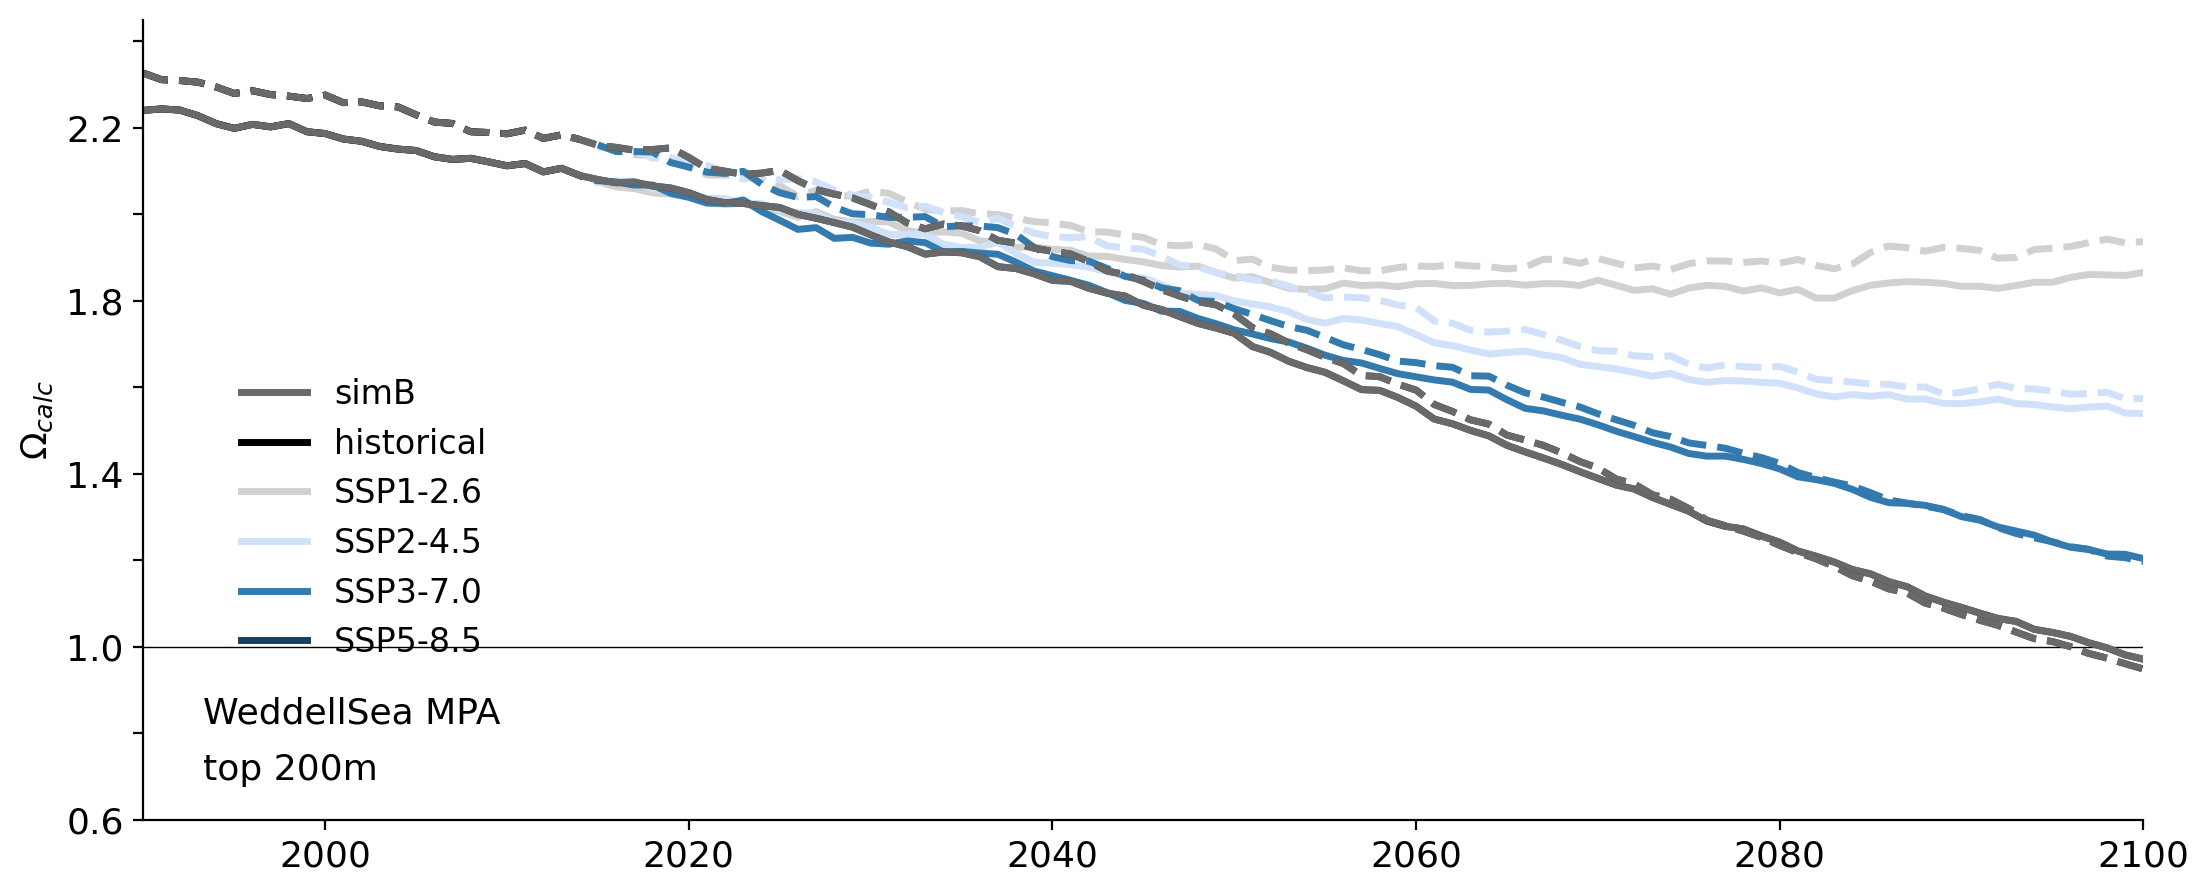

Process  Orkney_MPA


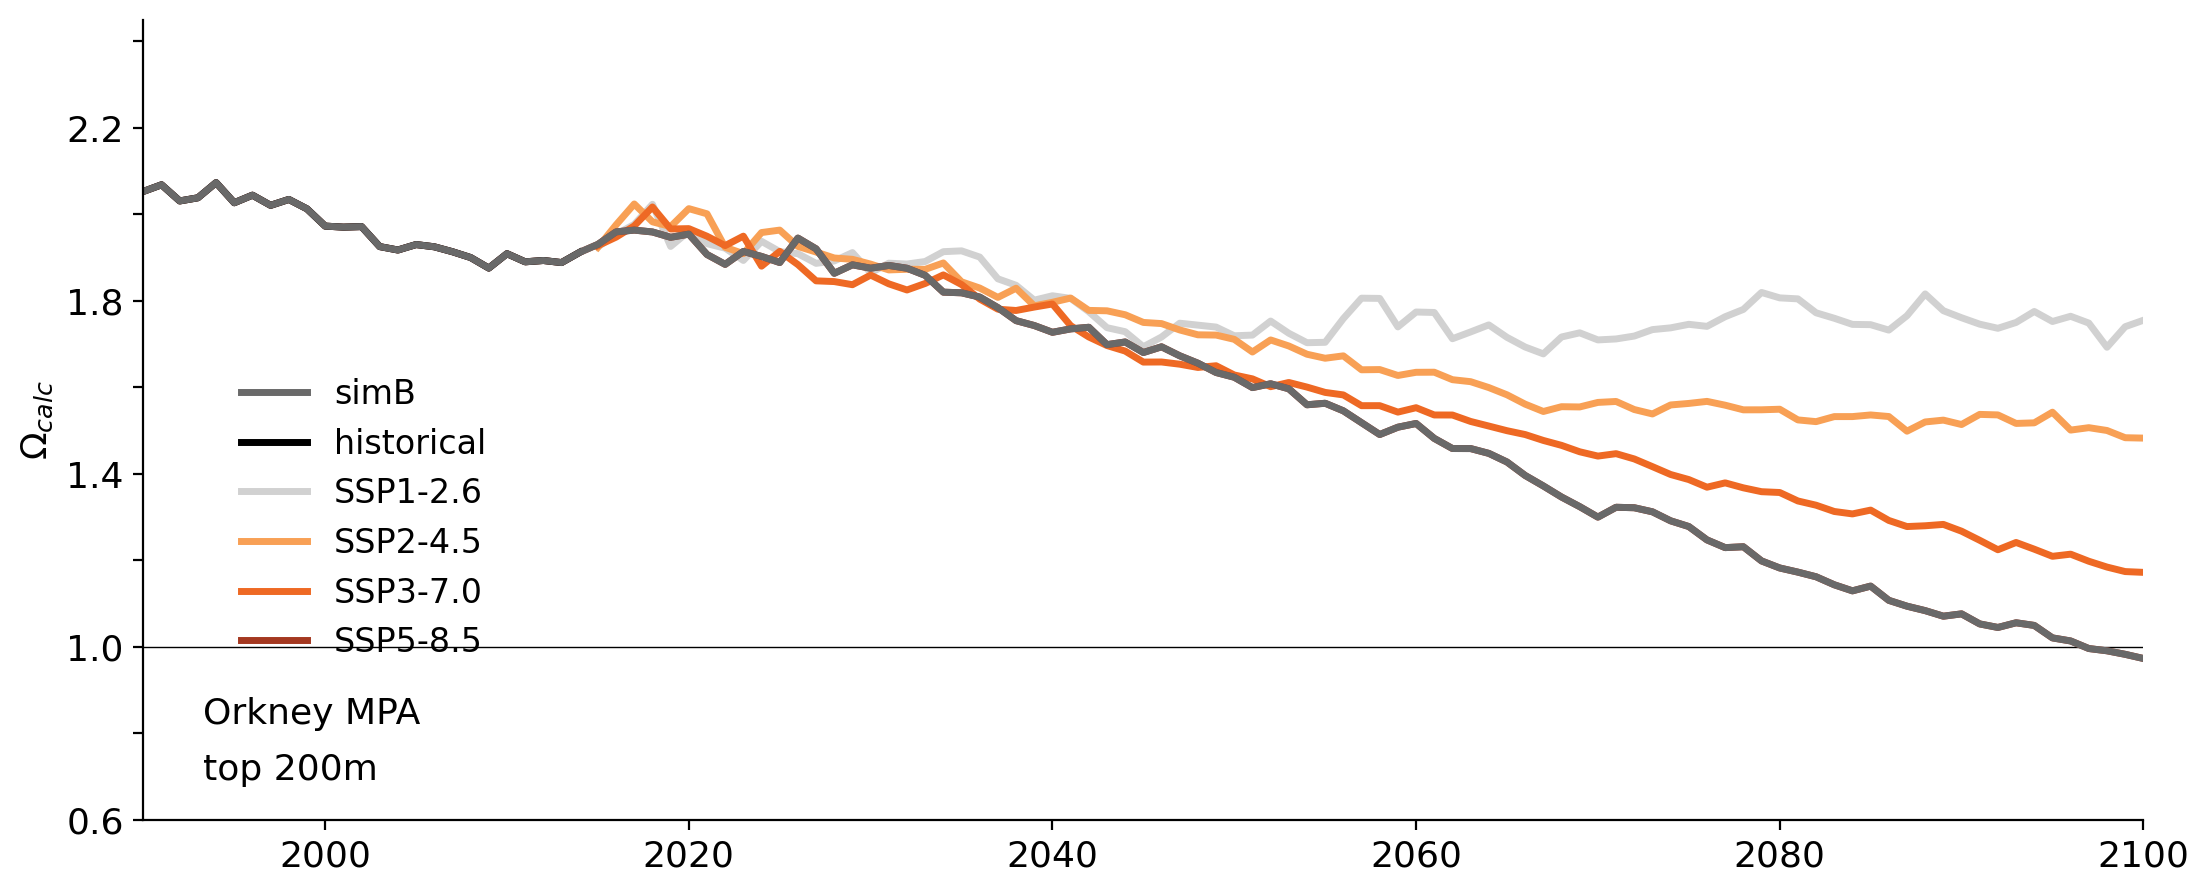

Process  East_Antarctica_all_MPA
Also load  East_Antarctica_all_MPA_shelf


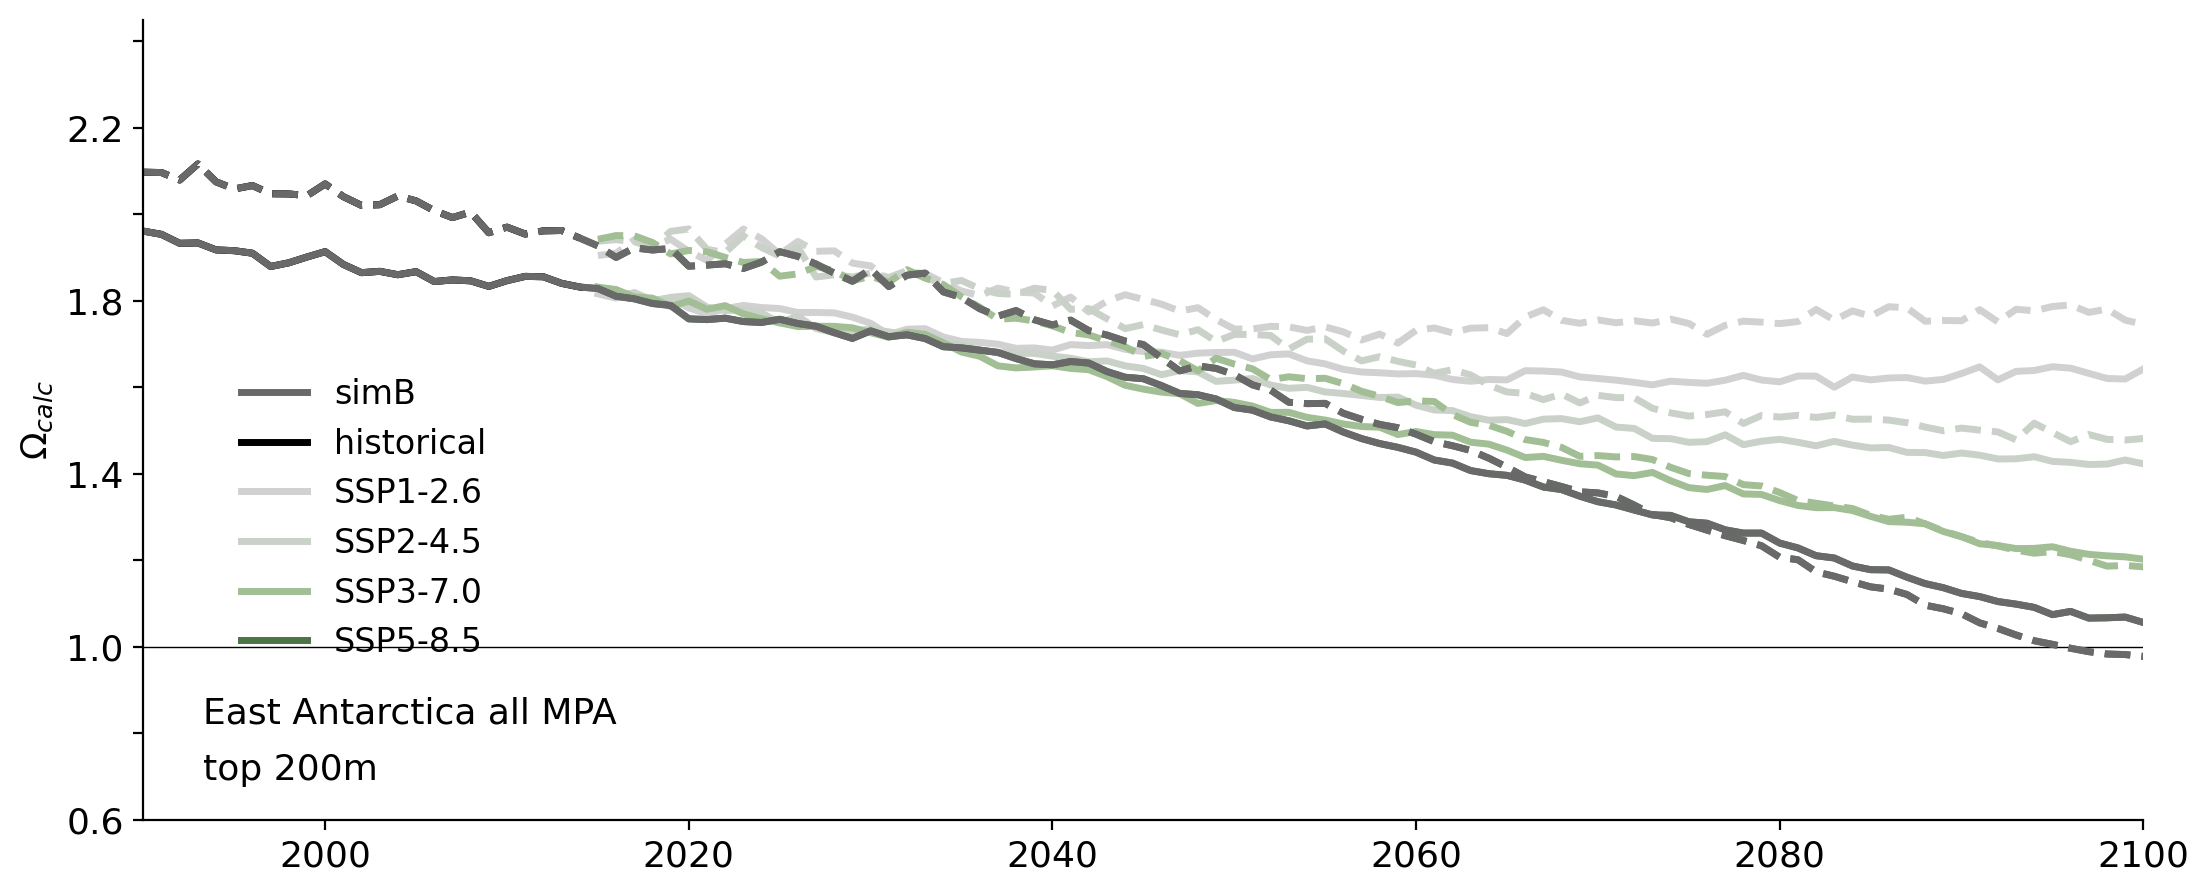

Process  AntarcticPeninsula_MPA
Also load  AntarcticPeninsula_MPA_shelf


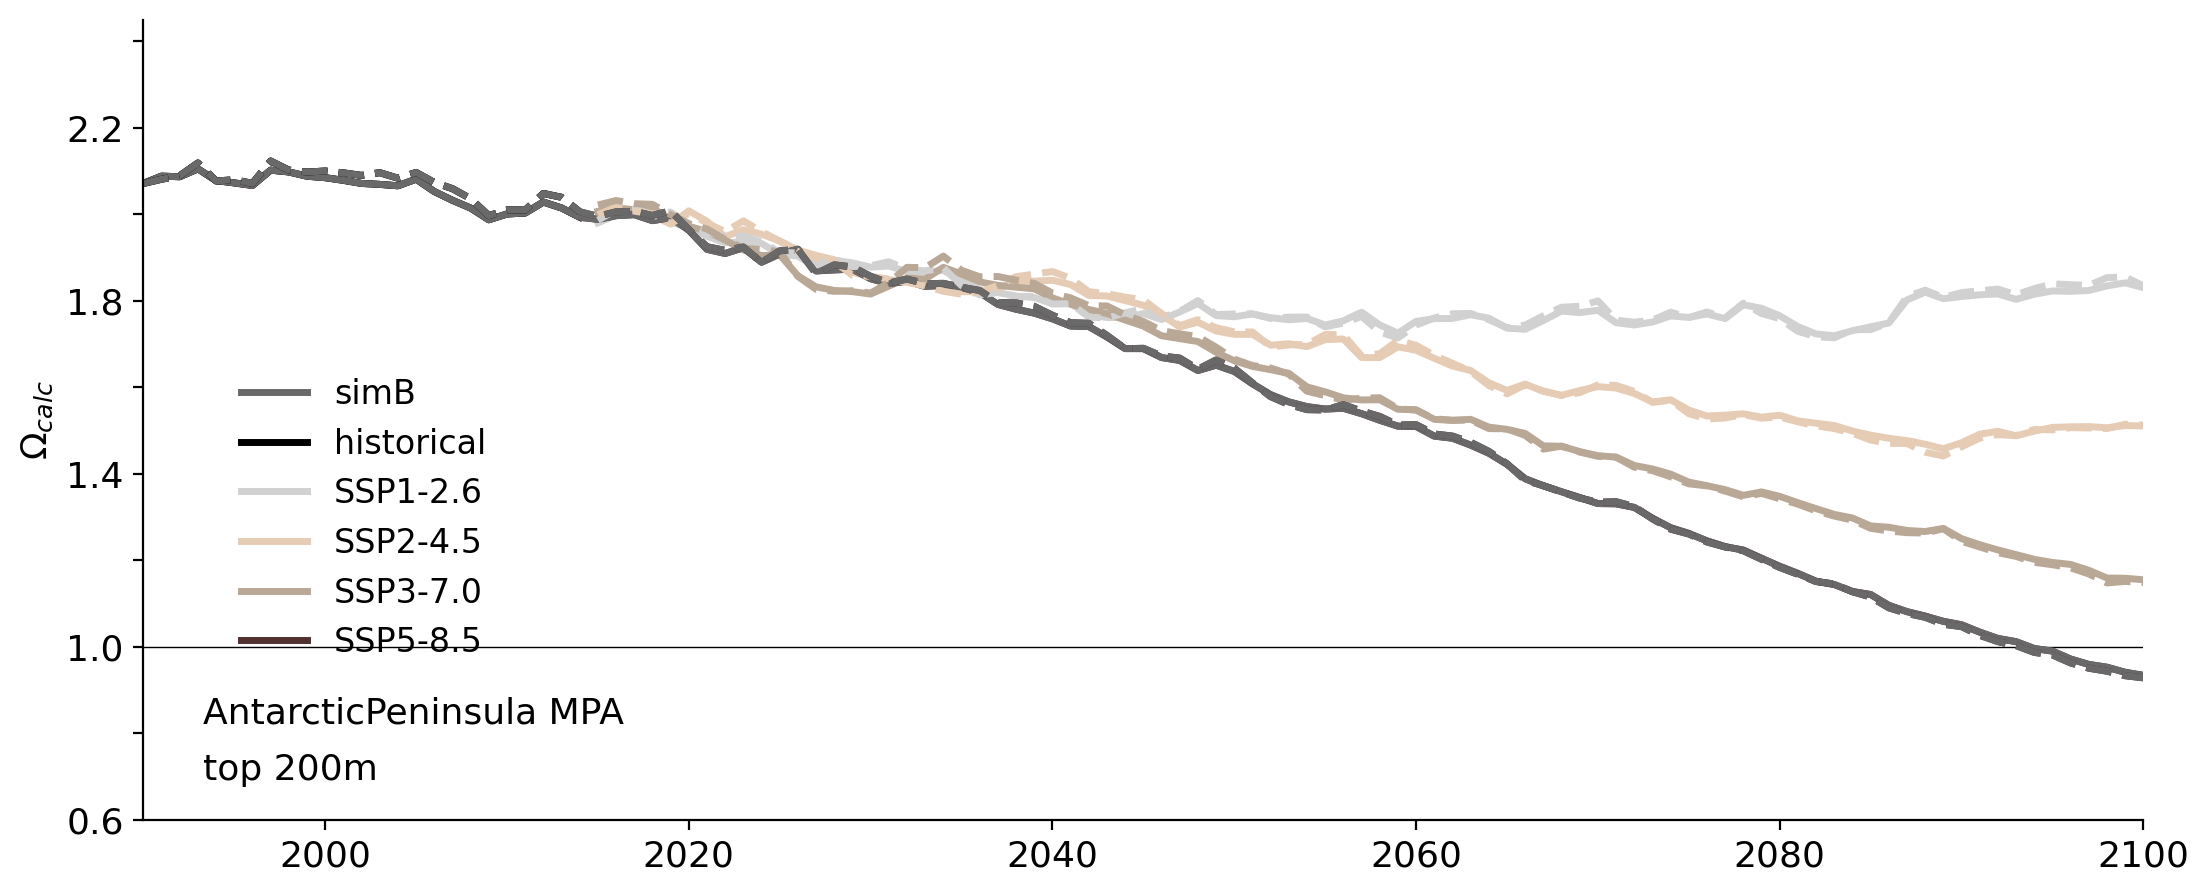

Process  bottom
Load  omegaA_avg_bottom omegaC_avg_bottom
data_all_Arag.shape (months x years x regions x simulations): (12, 111, 31, 5)
Process  RossSea_MPA
Also load  RossSea_MPA_shelf


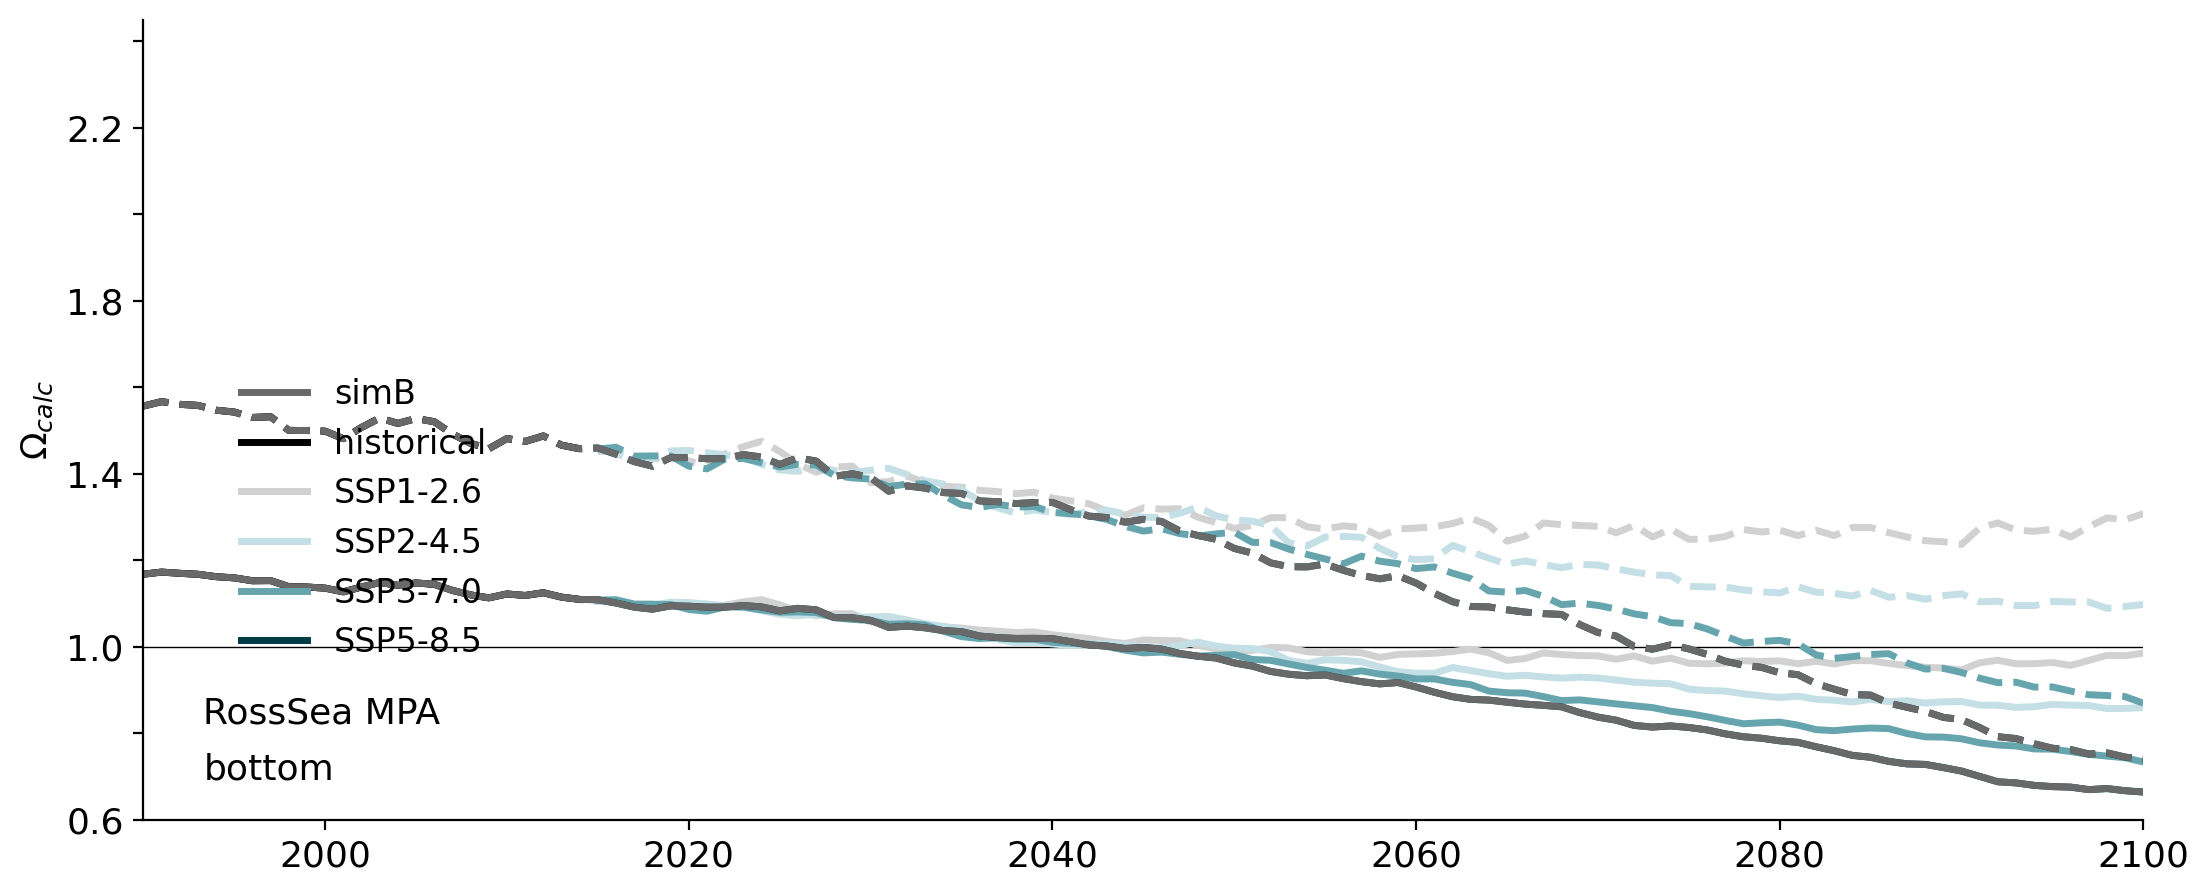

Process  WeddellSea_MPA
Also load  WeddellSea_MPA_shelf


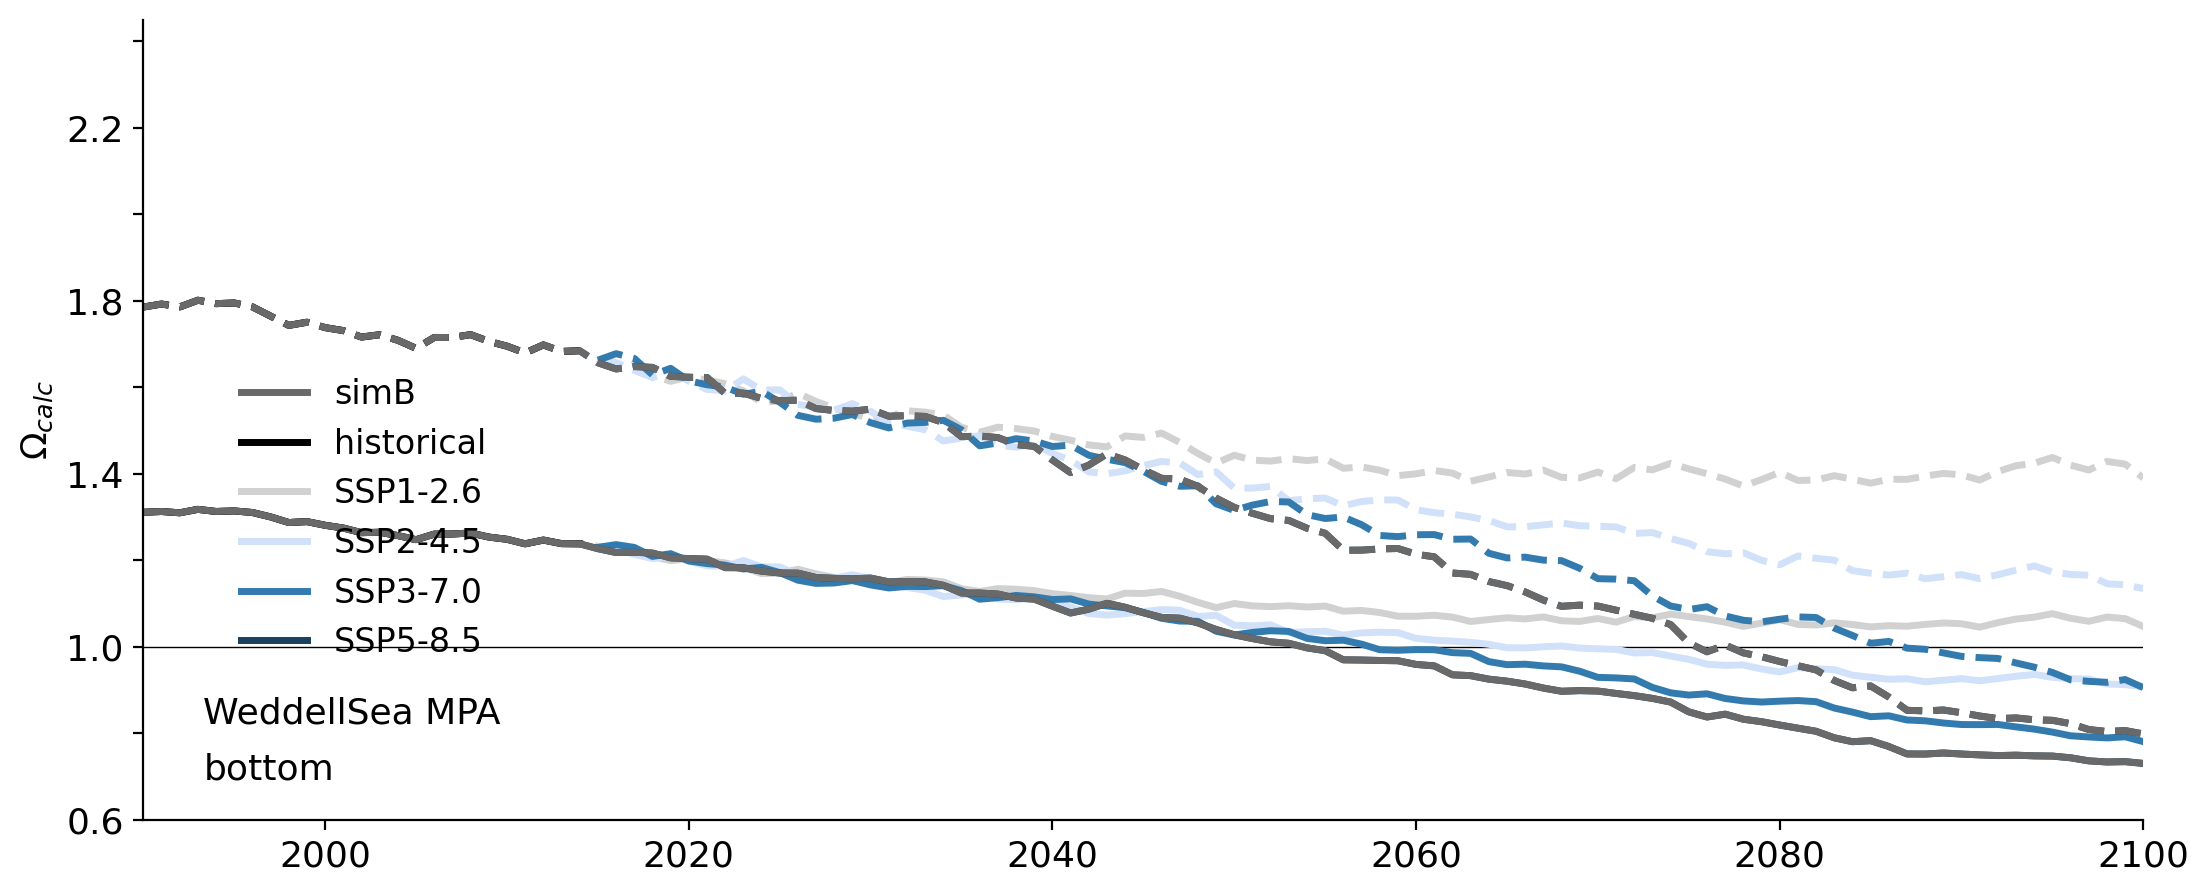

Process  Orkney_MPA


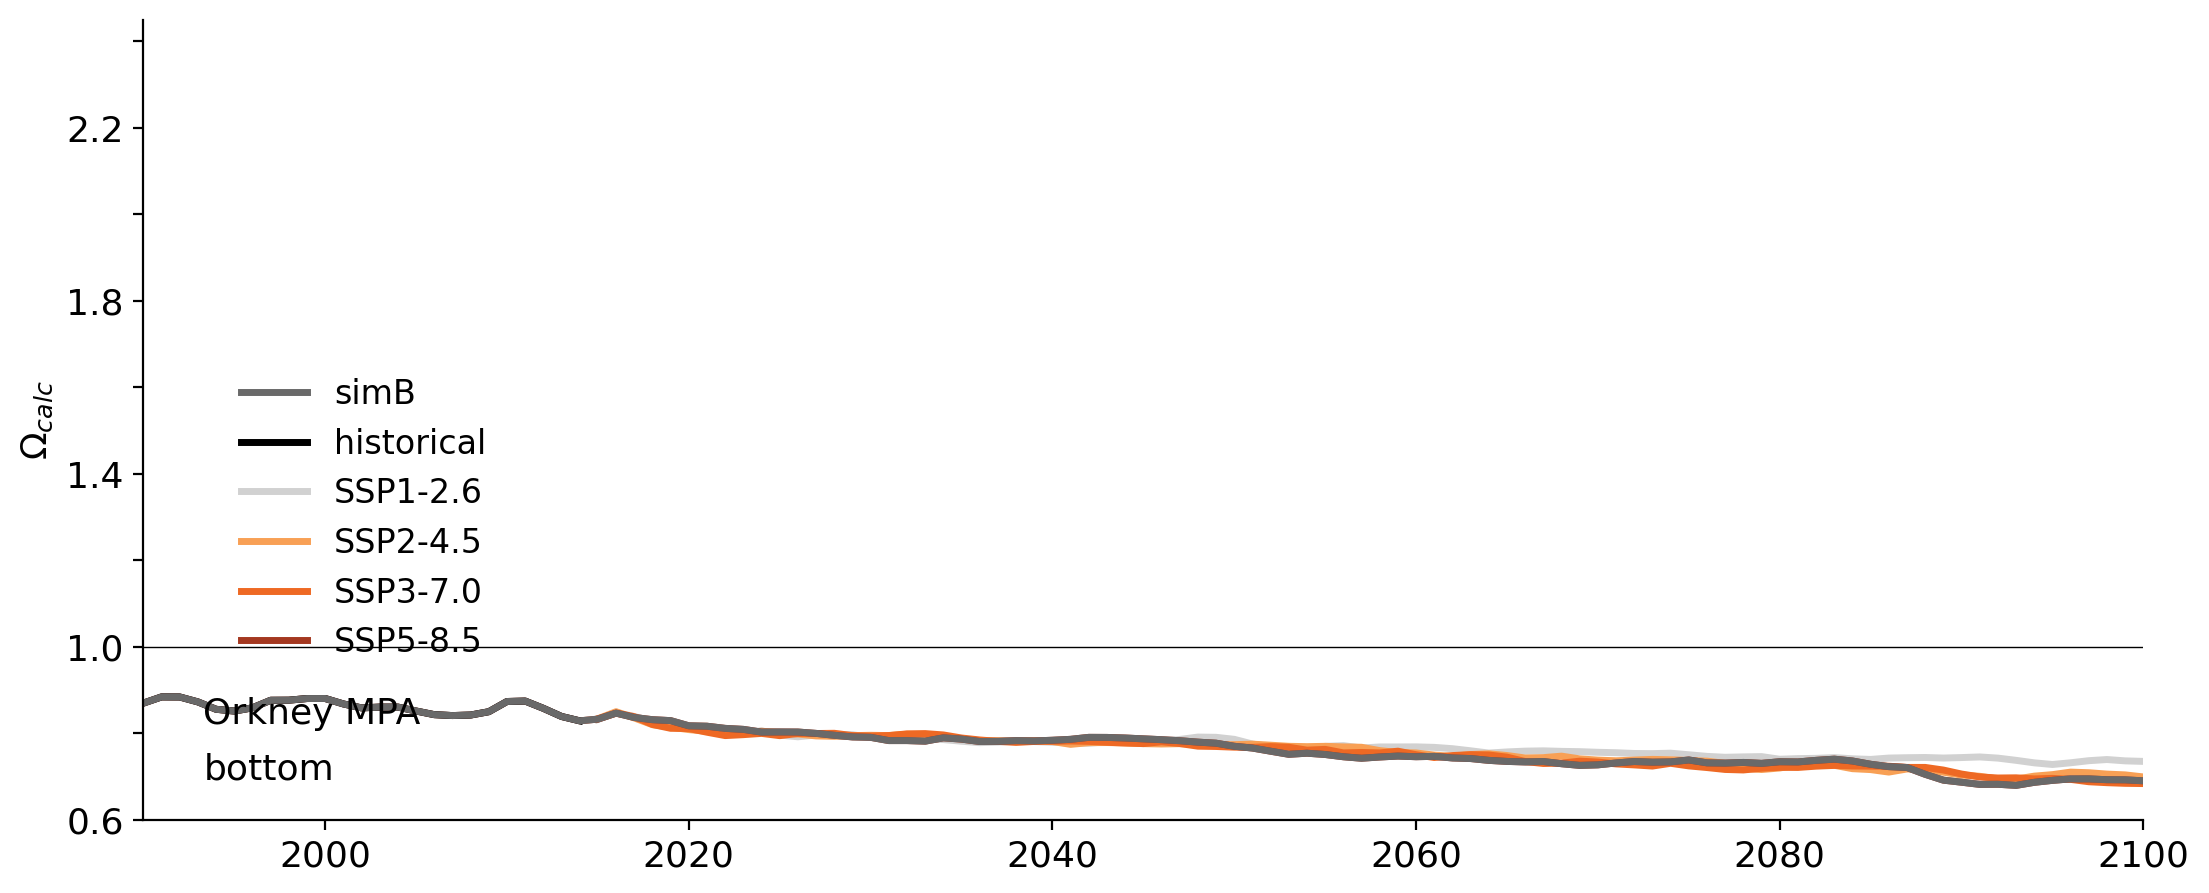

Process  East_Antarctica_all_MPA
Also load  East_Antarctica_all_MPA_shelf


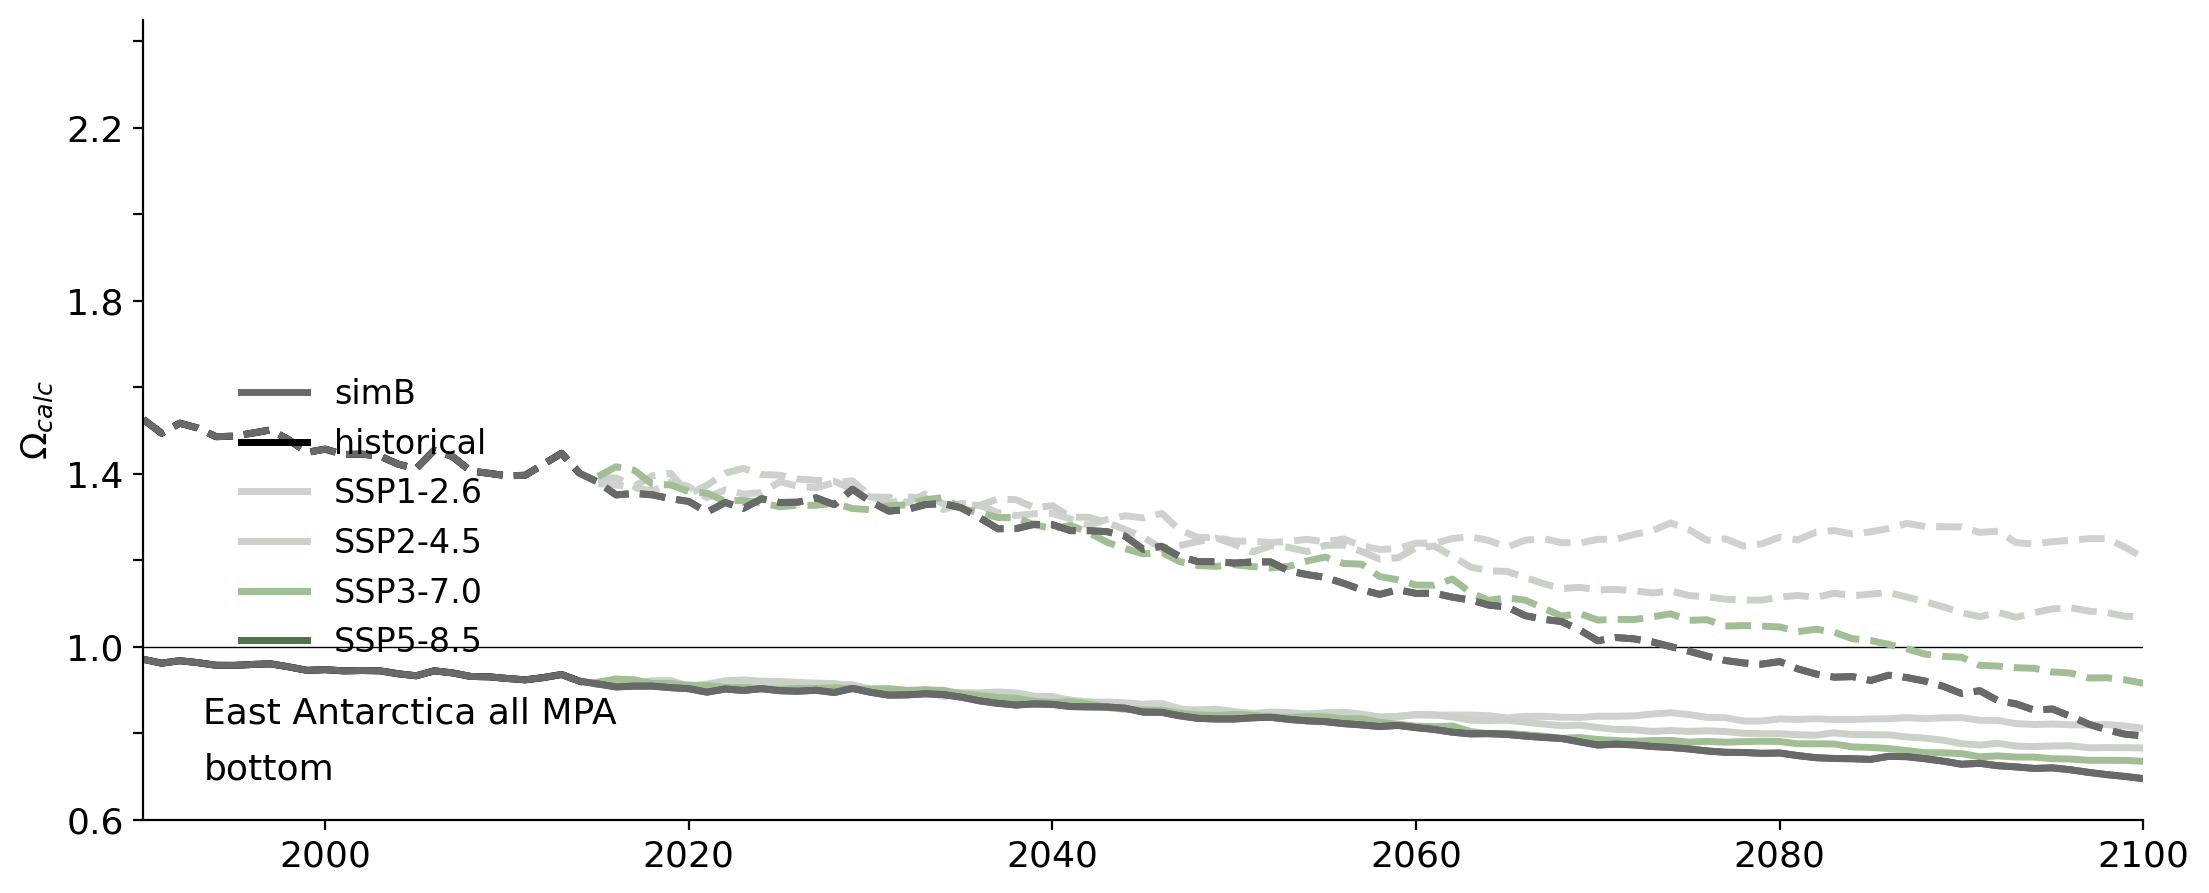

Process  AntarcticPeninsula_MPA
Also load  AntarcticPeninsula_MPA_shelf


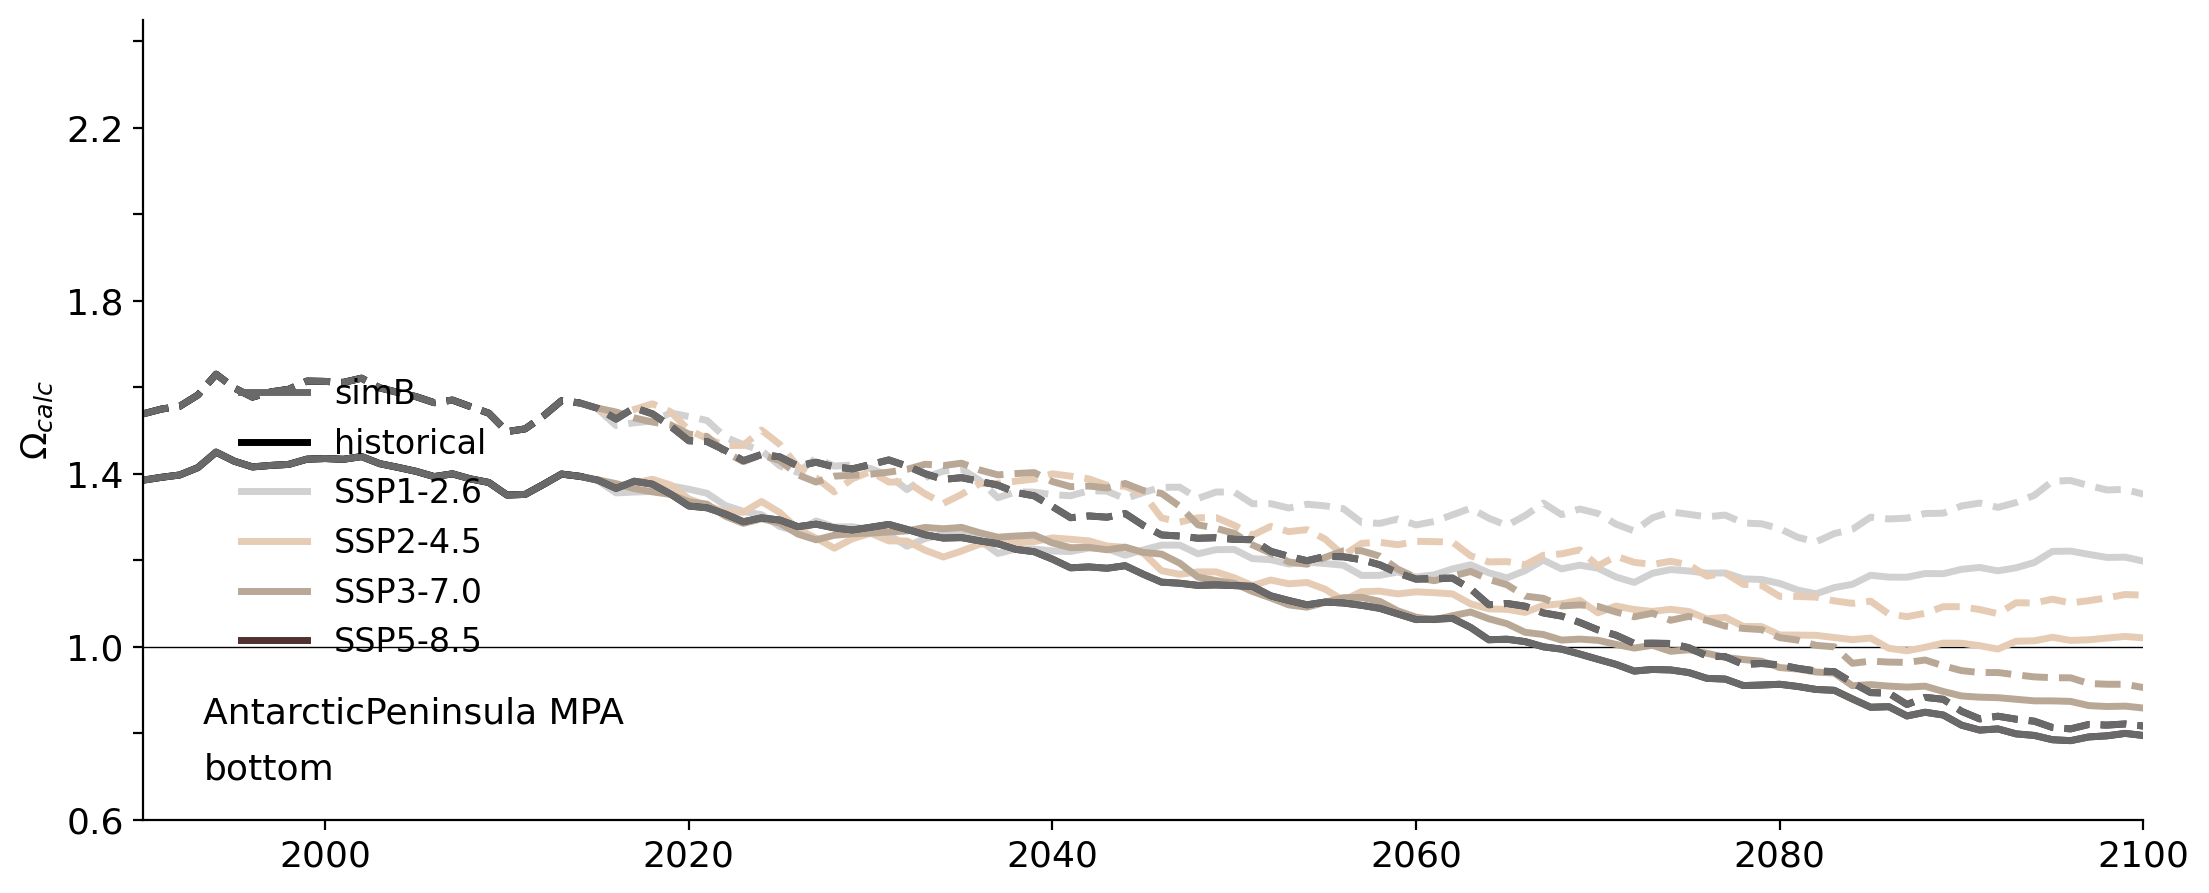

done


In [10]:
#----
# time series of omegaC (not in paper)
#----

save_plots = False
display_plots = True
plot_eps = False
                
depth_level_list = ['top200','bottom'] 

# list of regions in file
# NOTE: AntarcticPeninsula_MPA_v0 and AntarcticPeninsula_MPA are identical -> was stored twice in *nc files
subregions = ['all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
             'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
              'WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
              'Orkney_MPA','AntarcticPeninsula_MPA_v0',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
              'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_openOcean','East_Antarctica_2_MPA_openOcean',\
              'East_Antarctica_3_MPA_openOcean','East_Antarctica_all_MPA_openOcean',\
             'AntarcticPeninsula_MPA','AntarcticPeninsula_MPA_shelf','AntarcticPeninsula_MPA_openOcean']

subregions_plot = ['WeddellSea_MPA','East_Antarctica_all_MPA','RossSea_MPA','AntarcticPeninsula_MPA','Orkney_MPA']

sim_list = ['ssp585','ssp370','ssp245','ssp126','simB']
sim_list2 = ['SSP5-8.5','SSP3-7.0','SSP2-4.5','SSP1-2.6','simB']

fs = 13
lw = 2.5
dpicnt = 200
            
for dd in range(0,2):#len(depth_level_list)):
    depth_level = depth_level_list[dd] 
    print ('Process ',depth_level)
    
    vari1 = 'omegaA_avg_'+depth_level  
    vari2 = 'omegaC_avg_'+depth_level
    dataA_avg,dataC_avg = get_data(vari1,vari2,path_to_data)

    for rr in [8,11,14,19,28]: # HARD-CODED
        if subregions[rr] in subregions_plot: # only continue for the five regions of interest for the paper
            rr = subregions.index(subregions[rr])
            print ('Process ',subregions[rr])

            dataC_avg_a = np.mean(dataC_avg[:,:,rr,:],axis=0)

            if subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
                                    'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
                                    'Orkney_MPA','AntarcticPeninsula_MPA',\
                                    'East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']:
                if subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean']:
                    color_list = color_list3
                elif subregions[rr] in ['RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean']:
                    color_list = color_list1
                elif subregions[rr] in ['Orkney_MPA']:
                    color_list = color_list4
                elif subregions[rr] in ['AntarcticPeninsula_MPA']:
                    color_list = color_list5
                elif subregions[rr] in ['East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']:
                    color_list = color_list2
            else:
                color_list = color_list6
                
            color1 = color_list[0] 
            color2 = color_list[1] 
            color3 = color_list[2] 
            color4 = color_list[3] 

            #---
            # check if shelf region should be loaded
            if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                rr2 = subregions.index(subregions[rr]+'_shelf')
                print ('Also load ',subregions[rr2])

                dataC_avg_a_shelf = np.mean(dataC_avg[:,:,rr2,:],axis=0)
            #-----

            #---
            # have all scenarios in a single plot
            #---
            plot_combined = True
            if plot_combined:

                years = np.arange(1990,2100+1,1)

                fig7= plt.figure(num=18, figsize=(10,4), dpi=dpicnt, facecolor='w', edgecolor='k')
                ax = fig7.add_axes([0, 0, 1, 1])

                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                #ax.spines['bottom'].set_visible(False)
                #ax.spines['left'].set_visible(False)

                plt.hlines(1,years[0],years[-1],color='black',linewidth=0.5)

                ls = '-'
                # ssp585
                ss = 3
                plt.plot(years,dataC_avg_a[:,ss],color=color4,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp370
                ss = 2
                plt.plot(years,dataC_avg_a[:,ss],color=color3,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp245
                ss = 1
                plt.plot(years,dataC_avg_a[:,ss],color=color2,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # ssp126
                ss = 0
                plt.plot(years,dataC_avg_a[:,ss],color=color1,linewidth=lw,linestyle=ls,label=sim_list2[ss])

                # historical
                plt.plot(years[0:25],dataC_avg_a[0:25,ss],color='k',linewidth=lw,linestyle=ls,label='historical')

                ss = 4
                plt.plot(years,dataC_avg_a[:,ss],color='dimgrey',linewidth=lw,linestyle=ls,label='simB')

                # plot shelf regions (if applicable)
                if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                    ls = '--'
                    # ssp585
                    ss = 3
                    plt.plot(years,dataC_avg_a_shelf[:,ss],color=color4,linewidth=lw,linestyle=ls)
                    # ssp370
                    ss = 2
                    plt.plot(years,dataC_avg_a_shelf[:,ss],color=color3,linewidth=lw,linestyle=ls)
                    # ssp245
                    ss = 1
                    plt.plot(years,dataC_avg_a_shelf[:,ss],color=color2,linewidth=lw,linestyle=ls)
                    # ssp126
                    ss = 0
                    plt.plot(years,dataC_avg_a_shelf[:,ss],color=color1,linewidth=lw,linestyle=ls)
                    # historical
                    plt.plot(years[0:25],dataC_avg_a_shelf[0:25,ss],color='k',linewidth=lw,linestyle=ls)
                    ss = 4
                    plt.plot(years,dataC_avg_a_shelf[:,ss],color='dimgrey',linewidth=lw,linestyle=ls)
                    
                    
                handles, labels = plt.gca().get_legend_handles_labels() 
                order = [5,4,0,1,2,3] ##specify order of items in legend

                plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
                           loc='upper center', bbox_to_anchor=(0.11, 0.59),\
                                ncol=1,fancybox=True, frameon=False,shadow=False,prop={'size': 12})

                plt.yticks(fontsize=fs)
                plt.xticks(fontsize=fs)
                plt.xlim((years[0],years[-1]))
                plt.ylabel('$\Omega_{calc}$',fontsize=fs)
                
                plt.ylim((0.65,2.45))
                plt.yticks([0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4],[0.6,'',1.0,'',1.4,'',1.8,'',2.2,''],fontsize=fs)

                plt.annotate(subregions[rr].replace("_"," "),xy=(0.03,0.12), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')

                if depth_level in ['water_column']:
                    plt.annotate('whole water column',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['0_10']:
                    plt.annotate('0-10m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['10_100']:
                    plt.annotate('10-100m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['100_500']:
                    plt.annotate('100-500m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['below500']:
                    plt.annotate('below 500m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['bottom']:
                    plt.annotate('bottom',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')
                elif depth_level in ['top200']:
                    plt.annotate('top 200m',xy=(0.03,0.05), xycoords='axes fraction',\
                                             ha='left',fontsize=fs,color='black')

                if save_plots:
                    filename = 'TimeSeries_omegaC_FOR_PAPER_ALL_SIM_'+subregions[rr]+'_'+depth_level+'.png'
                    plt.savefig(savepath1+filename,dpi = dpicnt, bbox_inches='tight',format='png')
                    del filename

                if display_plots:
                    plt.show()
                else:
                    plt.close(fig7)
                    
                    
                #----
                # plot eps
                #----
                if plot_eps:
                    fig7= plt.figure(num=18, figsize=(10,4), dpi=dpicnt, facecolor='w', edgecolor='k')
                    ax = fig7.add_axes([0, 0, 1, 1])
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    plt.hlines(1,years[0],years[-1],color='black',linewidth=0.5)
                    ls = '-'
                    # ssp585
                    plt.plot(years,dataC_avg_a[:,3],color=color4,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp370
                    plt.plot(years,dataC_avg_a[:,2],color=color3,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp245
                    plt.plot(years,dataC_avg_a[:,1],color=color2,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # ssp126
                    plt.plot(years,dataC_avg_a[:,0],color=color1,linewidth=lw,linestyle=ls,label=sim_list2[ss])
                    # historical
                    plt.plot(years[0:25],dataC_avg_a[0:25,0],color='k',linewidth=lw,linestyle=ls,label='historical')

                    plt.plot(years,dataC_avg_a[:,4],color='dimgrey',linewidth=lw,linestyle=ls,label='simB')

                    # plot shelf regions (if applicable)
                    if subregions[rr] in ['WeddellSea_MPA','RossSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
                        ls = '--'
                        # ssp585
                        plt.plot(years,dataC_avg_a_shelf[:,3],color=color4,linewidth=lw,linestyle=ls)
                        # ssp370
                        plt.plot(years,dataC_avg_a_shelf[:,2],color=color3,linewidth=lw,linestyle=ls)
                        # ssp245
                        plt.plot(years,dataC_avg_a_shelf[:,1],color=color2,linewidth=lw,linestyle=ls)
                        # ssp126
                        plt.plot(years,dataC_avg_a_shelf[:,0],color=color1,linewidth=lw,linestyle=ls)
                        # historical
                        plt.plot(years[0:25],dataC_avg_a_shelf[0:25,0],color='k',linewidth=lw,linestyle=ls)
                        plt.plot(years,dataC_avg_a_shelf[:,4],color='dimgrey',linewidth=lw,linestyle=ls)

                    plt.yticks(fontsize=fs)
                    plt.xticks([2000,2020,2040,2060,2080,2100],[],fontsize=fs)
                    plt.xlim((years[0],years[-1]))
                    
                    plt.ylim((0.65,2.45))
                    plt.yticks([0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4],[],fontsize=fs)

                    if save_plots:
                        filename = 'TimeSeries_omegaC_FOR_PAPER_ALL_SIM_'+subregions[rr]+'_'+depth_level+'.eps'
                        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
                        del filename

                    if display_plots:
                        plt.show()
                    else:
                        plt.close(fig7)

            del dataC_avg_a
            
print ('done')




In [9]:
print (savepath1)

/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_TimeSeries/
